# Accumulation radar - investigation
***
### Last update: November 16th, 2020 at 12h00

# I. MacFerrin's code brief explanation:
Ice slabs processing is done is in `IceBridgeManager_v2.py`. You need the path to several folders where some exclusions files are stored and where you save the data into that are defined in `GPR_FileData.py`.
To understand ice slabs processing, go to the end of the code `IceBridgeManager_v2.py` to the following statements:

if __name__ == "__main__":

    ib = IceBridgeGPR_Manager_v2()
    pdb.set_trace()
    #ib.export_KML_reference_tracks()
    ib.export_ice_layer_lat_lon_distance_thicknesses()
    # Le 12 Septembre 2020, je sors sans erreur de export_ice_layer_lat_lom_distance_thicknesses!
    #ib.export_smoothed_ice_layer_shapefile()
    pdb.set_trace()

    for track in ib.tracks:
        track.DO_IT_ALL()
        
The way of processing the data is a bit messy, you start by doing some stuffs in the `ib.export_ice_layer_lat_lon_distance_thicknesses()` function and then going into the function `DO_IT_ALL()`. I suggest to start by going into the function `DO_IT_ALL()` that list the important steps:

    def DO_IT_ALL(self):

        self._read_metadata()
        
        self.compute_surface_picks(export=True)

        self.perform_roll_correction(export=True, max_depth_m=100)

        self.perform_depth_correction(export=True, max_depth_m=100)

        self.identify_ice_lenses(export=True, max_depth_m=20)
        
        
1. You start by reading the data in `self._read_metadata()`, where you read the database having all accumulation radar bata in it, a database that have been created by running the code `IceBridgeRadarFlightlineDB.py` beforehand.
2. Then you identify the surface of the icesheet in the radargram in the function `self.compute_surface_picks(export=True)`. It can be done automatically; if it does it wrong, you can specifyths surface yourself by reading the file `SURFACE_STARTING_PICKS_Suggestions.txt`.
3. Then you want to correct the radargram due to the roll of the aircraft in the function `self.perform_roll_correction(export=True, max_depth_m=100)`. For the theory behind that, see Section S.2.3. in the supplementary materials of MacFerrin et al., 2019, especially Fig. 10 explain it well: https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-019-1550-3/MediaObjects/41586_2019_1550_MOESM1_ESM.pdf. Note: you select the first 100m from the surface from now on to process the data.
4. Then you want to correct the radar signal return because of the signal penetration at depth in the function `self.perform_depth_correction(export=True, max_depth_m=100)`. For the theory behind that, see Section S.2.5. in the supplementary materials of MacFerrin et al., 2019, especially Fig. 12.
5. Once data is ready to work with, you want to identify the ice lenses in the data in the function `self.identify_ice_lenses(export=True, max_depth_m=20)`. Here you focus only on the first 20 meters below the surface. Mike has identified a threshold of the radar signal above which a pixel is considered as icy material by matching accumulation radar data with in-situ data collected from a GPR in 2010 (see Sect. 2.6. in the supplementary materials). Thus all of his data processing of ice slabs identification relies on this matching. That is why I am deeply convinced that instrumental setup of the accumulation radar is determining in ice slabs identification from his routine.

### Now that you know how is working Mike's code, I am going into the guts of the data

# II. Introduction
### 1. To process data to identify ice slabs, I need the following key elements
- A radar echogram matrix (n,m), where the radar echo at any nth depth and mth horizontal distance is recorded
- A 2 way-travel time vector (n) to compute the depth
- A latitude vector (m) to retreive the location
- A longitude vector (m) to retreive the location
- The 'roll' of the aircraft to compute roll correction of the radar signal

In the table below I summarize for each year of data I am interesting in ice slabs mapping if these variables are present, and what are their names:

|  Variable  |   2002   |   2003   |   2009   |   2010   |   2011   |   2012   |   2013   |   2014   |   2017   |   2018   |
| ---------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- | -------- |
|  Latitude  |yes (work in progress)|yes (work in progress)|          |    yes   |    yes   |    yes   |    yes   |    yes   |    yes   | to come |
|  Longitude |yes (work in progress)|yes (work in progress)|          |    yes   |    yes   |    yes   |    yes   |    yes   |    yes   | to come |
|  2-w time  |yes (manually)|yes (manually)|          |    yes   |    yes   |    yes   |    yes   |    yes   |    yes   | to come |
|  Echogram  |    yes   |    yes   |          |    yes   |    yes   |    yes   |    yes   |    yes   |    yes   | to come |
|    Roll    |     no   |     no   |          |    yes   |    yes   |    yes   |    yes   |    yes   |    yes   | to come |

Note that Mike MacFerrin has already processed data from 2010 to 2014. I am in contact with John Paden (Center for Remote Sensing of Ice Sheets - CReSIS), who is in charge of the data processing of the accumulation radar. He told me that 2018 data are expected to be released by the end of this year.

So far, I have been focusing on 2002, 2003 and 2017 data. Here is the status for each year:

### 2. 2017. No issue
- This dataset is similar to the 2010-2014 dataset.
- Solved issue: I had a problem of vertical resolution for weeks regarding 2017 data, for the large majority of the dataset. John Paden told me there was indeed an issue in their data processing. He redirected me to another folder where data are stored, I made a test and this subdataset was processable using MacFerrin's routine. My guess is that 2017 dataset is processable.

### 3. 2002/2003: A few issues
- These datasets are not similar to the 2010-2014 dataset.
- Problem being solved: matching between two datasets fo retreive the latitude and longitue of the tracks. Not finished yet.
- Issues:
1. I miss the roll of the aircraft.
2. I used to miss the 2 way travel time, but John Paden told me how to process the fast-time axis:     
    Nt = size(data,2)     
    dt = 2.034489716724874e-09     
    t0 = 0; % Unknown so set to zero     
    Time = t0 + dt*(0:Nt-1)     
    
    Is the time variable valid for travel in air and through snow/ice? As far as I know, I think this should valid only for travel through snow/ice. Is the t0 variable important ? So far, here is what John Paden told me : "The time offset, t0, should be something small on the order of tens of nanoseconds to account for the system time delay. The system time delay is the time for the signal to propagate through the RF transmitter, antenna feed cables, and RF receiver. For layer tracing, the time offset is usually not important."
    
3. For the processing of the data, they maybe have not gone throught the same processing steps compared to 2010-2014 dataset, but this is not sure. 

4. No additional information to know more about these data. Example: no `README` file at all. John Paden: "The processing code and documentation are not well enough organized to make it easy to answer your questions and may even be insufficient for these old datasets."

### 4. Questions:

I do not know a lot regarding radar data making difficult to be sure of what I am doing, and if I am not missing important things.

1. How to make sure that the 2017 (and future 2018) dataset are identical in term of the internal layers they see through firn to be sure that we indeed observe ice slabs ? In other words, are they key radar setup to pay attention to, making a comparison suitable between the different dataset?
2. Same question for 2002-2003
3. Computation of the time variable in 2002-2003: how important is the t0? is the fast-time axis only valid in firn/snow?

# III. Dataset visualization:
### 1. 2010 example
Let's show an example of 2010 dataset to see the differences between 2002-2003 and 2010 datasets and see how an ice slab looks like.

In [1]:
#Import libraries
import scipy.io
import rasterio
from matplotlib import pyplot
import numpy as np
import h5py
import matplotlib.colors as mcolors
import pandas as pd

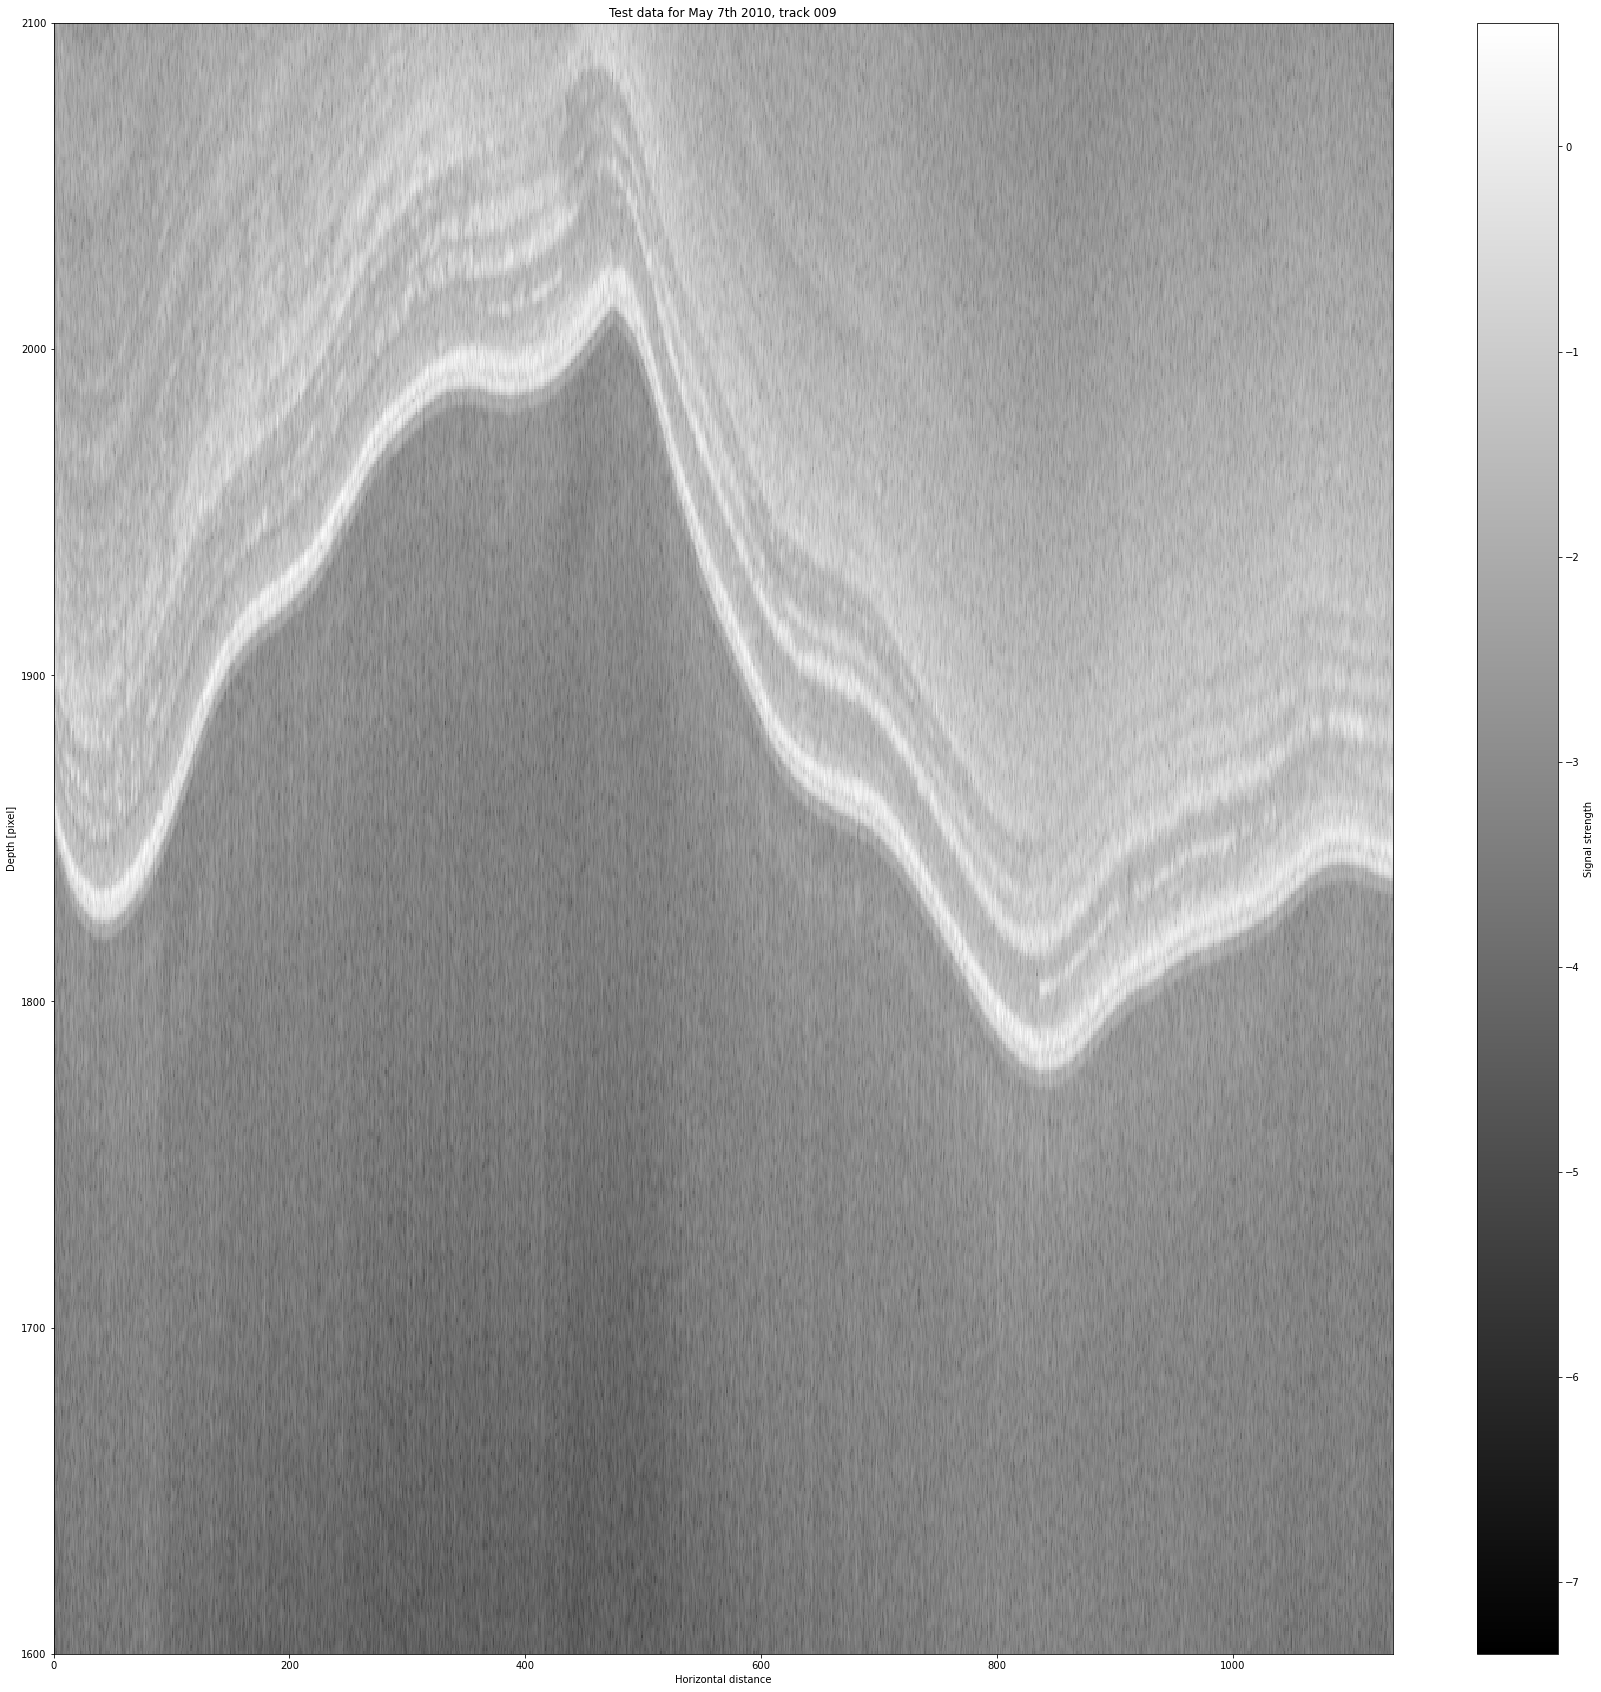

In [2]:
#Load a 2010 dataset
dset_20100507_01_009= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2010_Greenland_P3//CSARP_qlook//20100507_01//Data_20100507_01_009.mat')
data_20100507_01_009=dset_20100507_01_009['Data']

pyplot.rcParams["figure.figsize"]=30,30
# Plot dset_20100507_01_009
pyplot.figure()
#Change the size of the figure
color_map=pyplot.pcolor(np.log10(data_20100507_01_009),cmap=pyplot.get_cmap('gray'))
pyplot.ylabel('Depth [pixel]')
#pyplot.xticks(ticks=pd.Series(np.arange(0,len(lat_series),1)),labels=lat_series)
pyplot.xlabel('Horizontal distance')
pyplot.ylim(1600, 2100)
#pyplot.yticks(ticks=pd.Series(np.arange(0,len(height_series),1)),labels=height_series)
pyplot.title('Test data for May 7th 2010, track 009')
cbar=pyplot.colorbar()
cbar.set_label('Signal strength')
pyplot.show()
# ---------
print('Additional informations: this flight is a straigth line, a region where we do have ice slabs.')
print('Horizontal distance=[0,1100] <=> elevation=[1694,1778]')


### 2. Quicklook of 2002 data
I am showing in the following the plotting of 3 areas where I expect ice slabs for June, and one random echogram for May 18th 2002 (random because I do not have a pdf file for May quickly helping me to identify locations where I do have one for June 04).
### 2.a. June 04 2002, processed traces 3, 4, 5. I choose this example because we go from the ablation zone (begining of trace 3) to the dry snow zone (end of trace 4 already)

Additional informations: this flight is a straigth line, a region where we do have ice slabs.
Horizontal distance=[0,1100] <=> elevation=[1694,1778]
We have three variables stored in it: latitude, longitude, data
The dimensions of the data matrix is:
(1401, 1000)


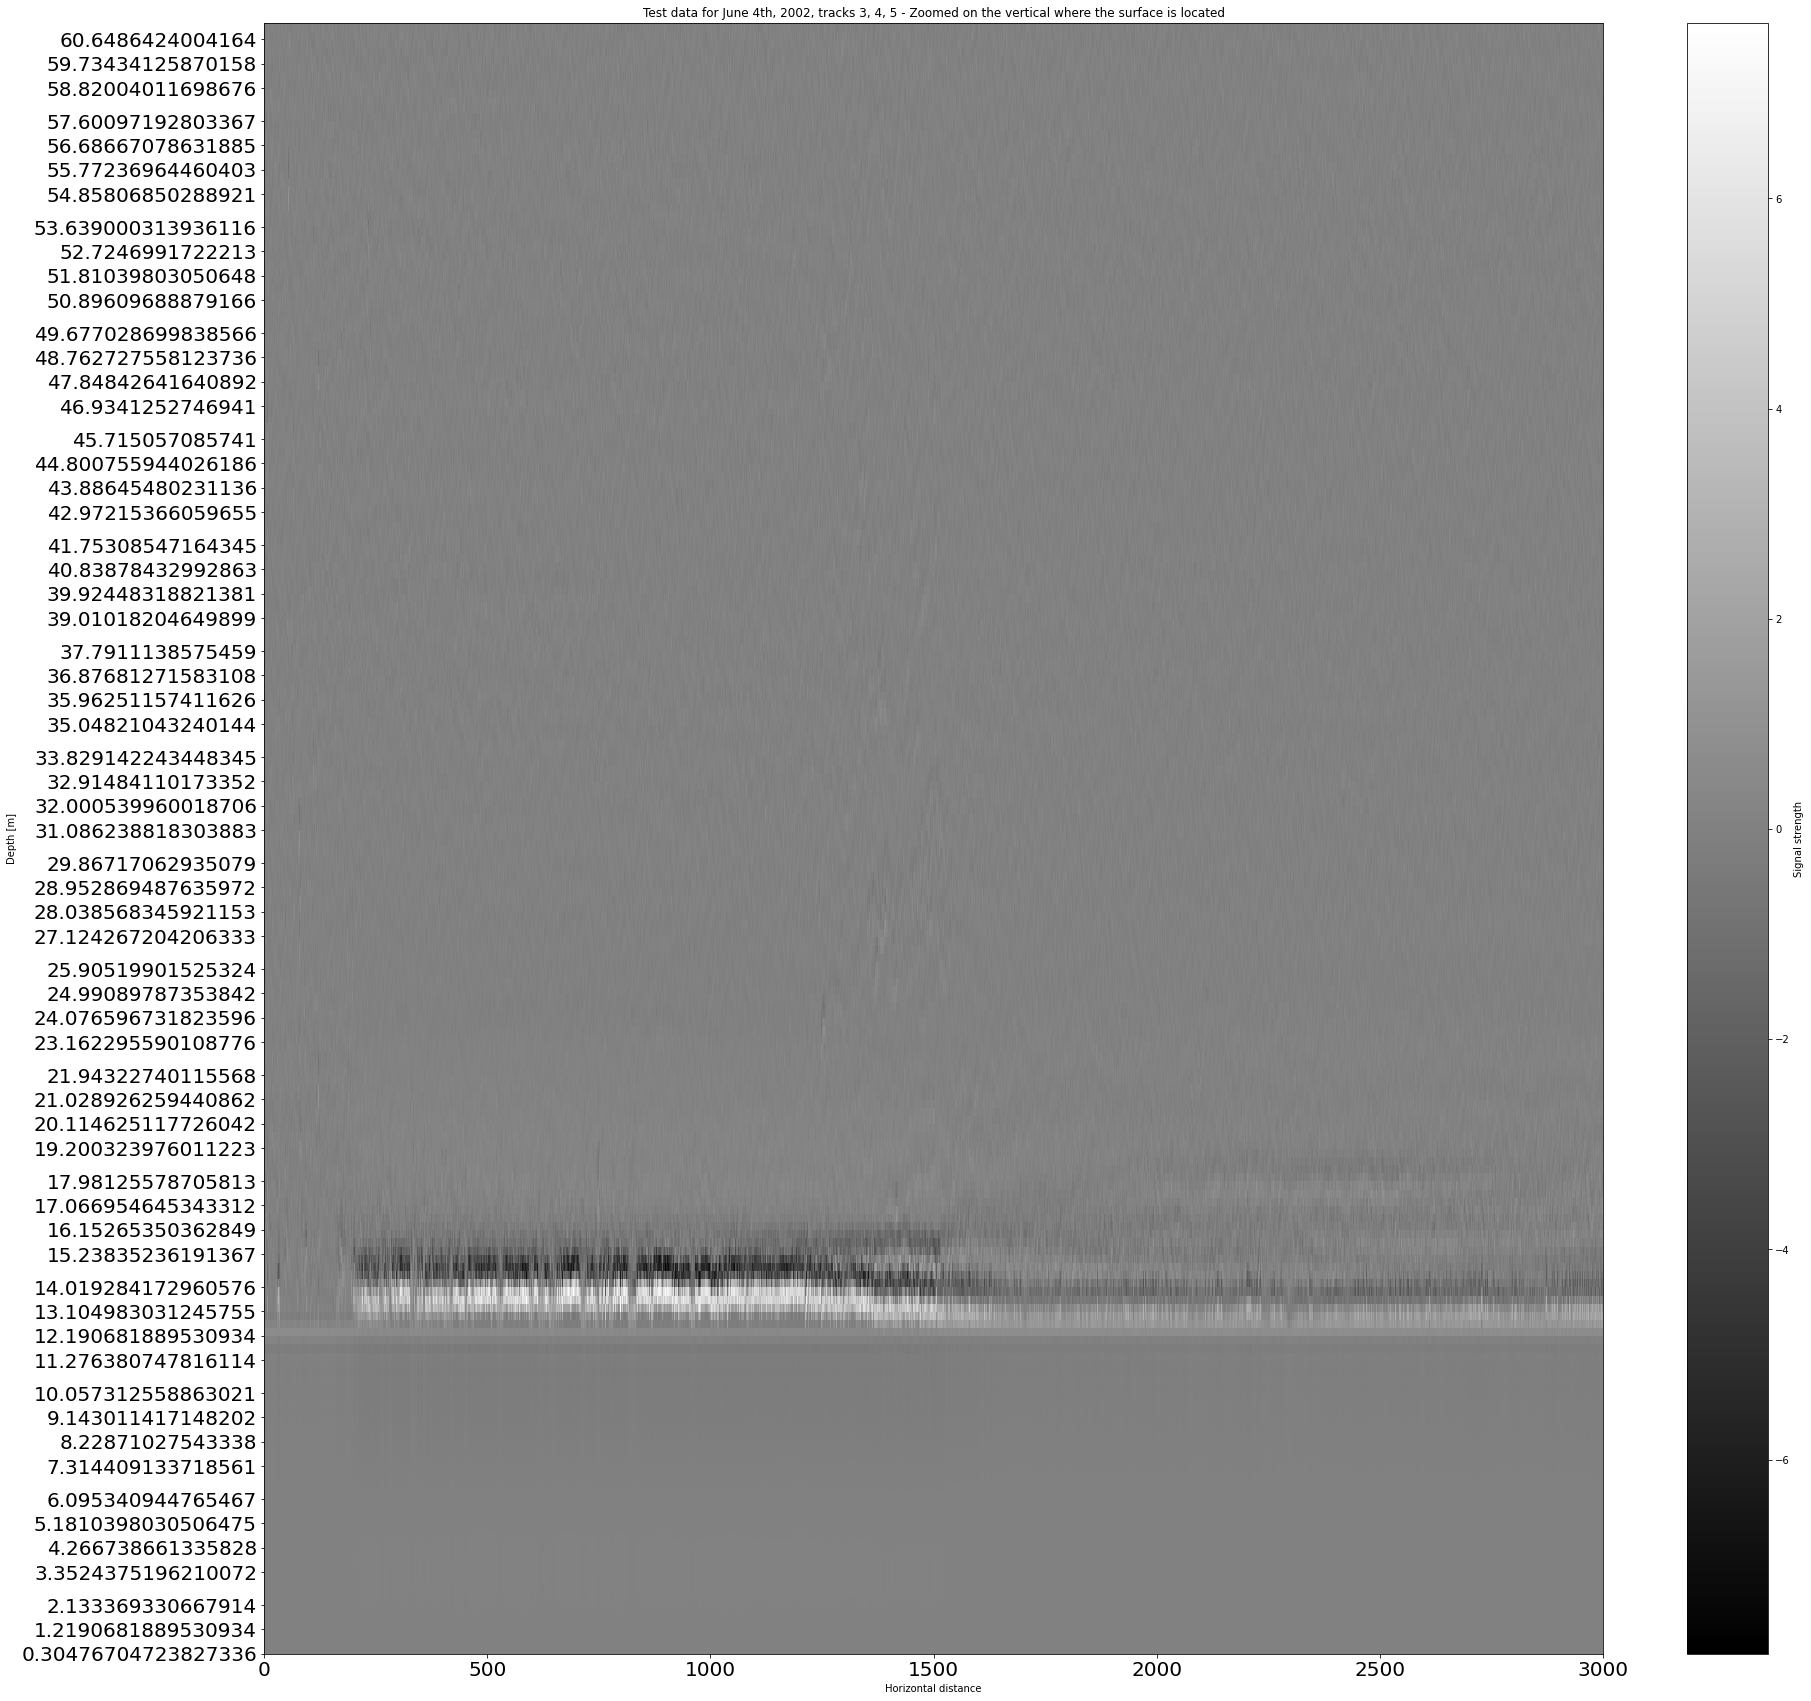

Additional informations: horizontal distance=[0,1000,1600,2000,3000] <=> elevation=[729,1525,1845,2037,2355]


In [3]:
#Load a data
jun04_02proc_3= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//jun04_02proc_3.mat')
jun04_02proc_4= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//jun04_02proc_4.mat')
jun04_02proc_5= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//jun04_02proc_5.mat')
#print(jun04_02proc_5)
print('We have three variables stored in it: latitude, longitude, data')


#Store the data into subdatasets
data_jun04_02proc_3=jun04_02proc_3['data']
lat_jun04_02proc_3=jun04_02proc_3['latitude']
lon_jun04_02proc_3=jun04_02proc_3['longitude']

data_jun04_02proc_4=jun04_02proc_4['data']
lat_jun04_02proc_4=jun04_02proc_4['latitude']
lon_jun04_02proc_4=jun04_02proc_4['longitude']

data_jun04_02proc_5=jun04_02proc_5['data']
lat_jun04_02proc_5=jun04_02proc_5['latitude']
lon_jun04_02proc_5=jun04_02proc_5['longitude']


#Print the size of the subdatasets
print('The dimensions of the data matrix is:')
print(data_jun04_02proc_5.shape)


#Append June 4 2002 data:
data_jun04_02proc_3_4=np.append(data_jun04_02proc_3,data_jun04_02proc_4,axis=1)
data_jun04_02proc_3_4_5=np.append(data_jun04_02proc_3_4,data_jun04_02proc_5,axis=1)

#Filter the data for plotting
#data_jun04_02proc_3_4_5[abs(data_jun04_02proc_3_4_5)<0.005]=np.nan
#data_jun04_02proc_3_4_5[abs(data_jun04_02proc_3_4_5)>5]=np.nan
#data_jun04_02proc_3_4_5

#Time computation according to John Paden's email.
Nt = data_jun04_02proc_4.shape[0]
dt = 2.034489716724874e-09
t0 = 0; # Unknown so set to zero
Time = t0 + dt*np.arange(1,Nt+1)
Time
#Modified Robin speed:
# self.C / (1.0 + (coefficient*density_kg_m3/1000.0))
v= 299792458 / (1.0 + (0.734*0.873/1000.0))
#calculate the depth:
#self.SAMPLE_DEPTHS = self.radar_speed_m_s * self.SAMPLE_TIMES / 2.0
depths = v * Time / 2.0

ticks_yplot=np.around(np.linspace(0, 1400, 432))
ticks_yplot=ticks_yplot.astype(int)
labels_yplot=depths[ticks_yplot]

#Change the size of the figure
pyplot.rcParams["figure.figsize"]=30,30
#Plot the data
pyplot.figure()
color_map=pyplot.pcolor(data_jun04_02proc_3_4_5,cmap=pyplot.get_cmap('gray'))#,norm=divnorm)
pyplot.ylabel('Depth [m]')
pyplot.xlabel('Horizontal distance')
pyplot.yticks(ticks=ticks_yplot,labels=labels_yplot)
pyplot.xticks(fontsize=20)
pyplot.yticks(fontsize=20)
pyplot.ylim(0, 200)
pyplot.title('Test data for June 4th, 2002, tracks 3, 4, 5 - Zoomed on the vertical where the surface is located')
cbar=pyplot.colorbar()
cbar.set_label('Signal strength')
pyplot.show()
# ---------
print('Additional informations: horizontal distance=[0,1000,1600,2000,3000] <=> elevation=[729,1525,1845,2037,2355]')

### 2.b. June 04 2020, processed traces 52, 53. I choose this example because we go from the dry snow zone (begining of trace 52) to the ablation zone (end of trace 53)

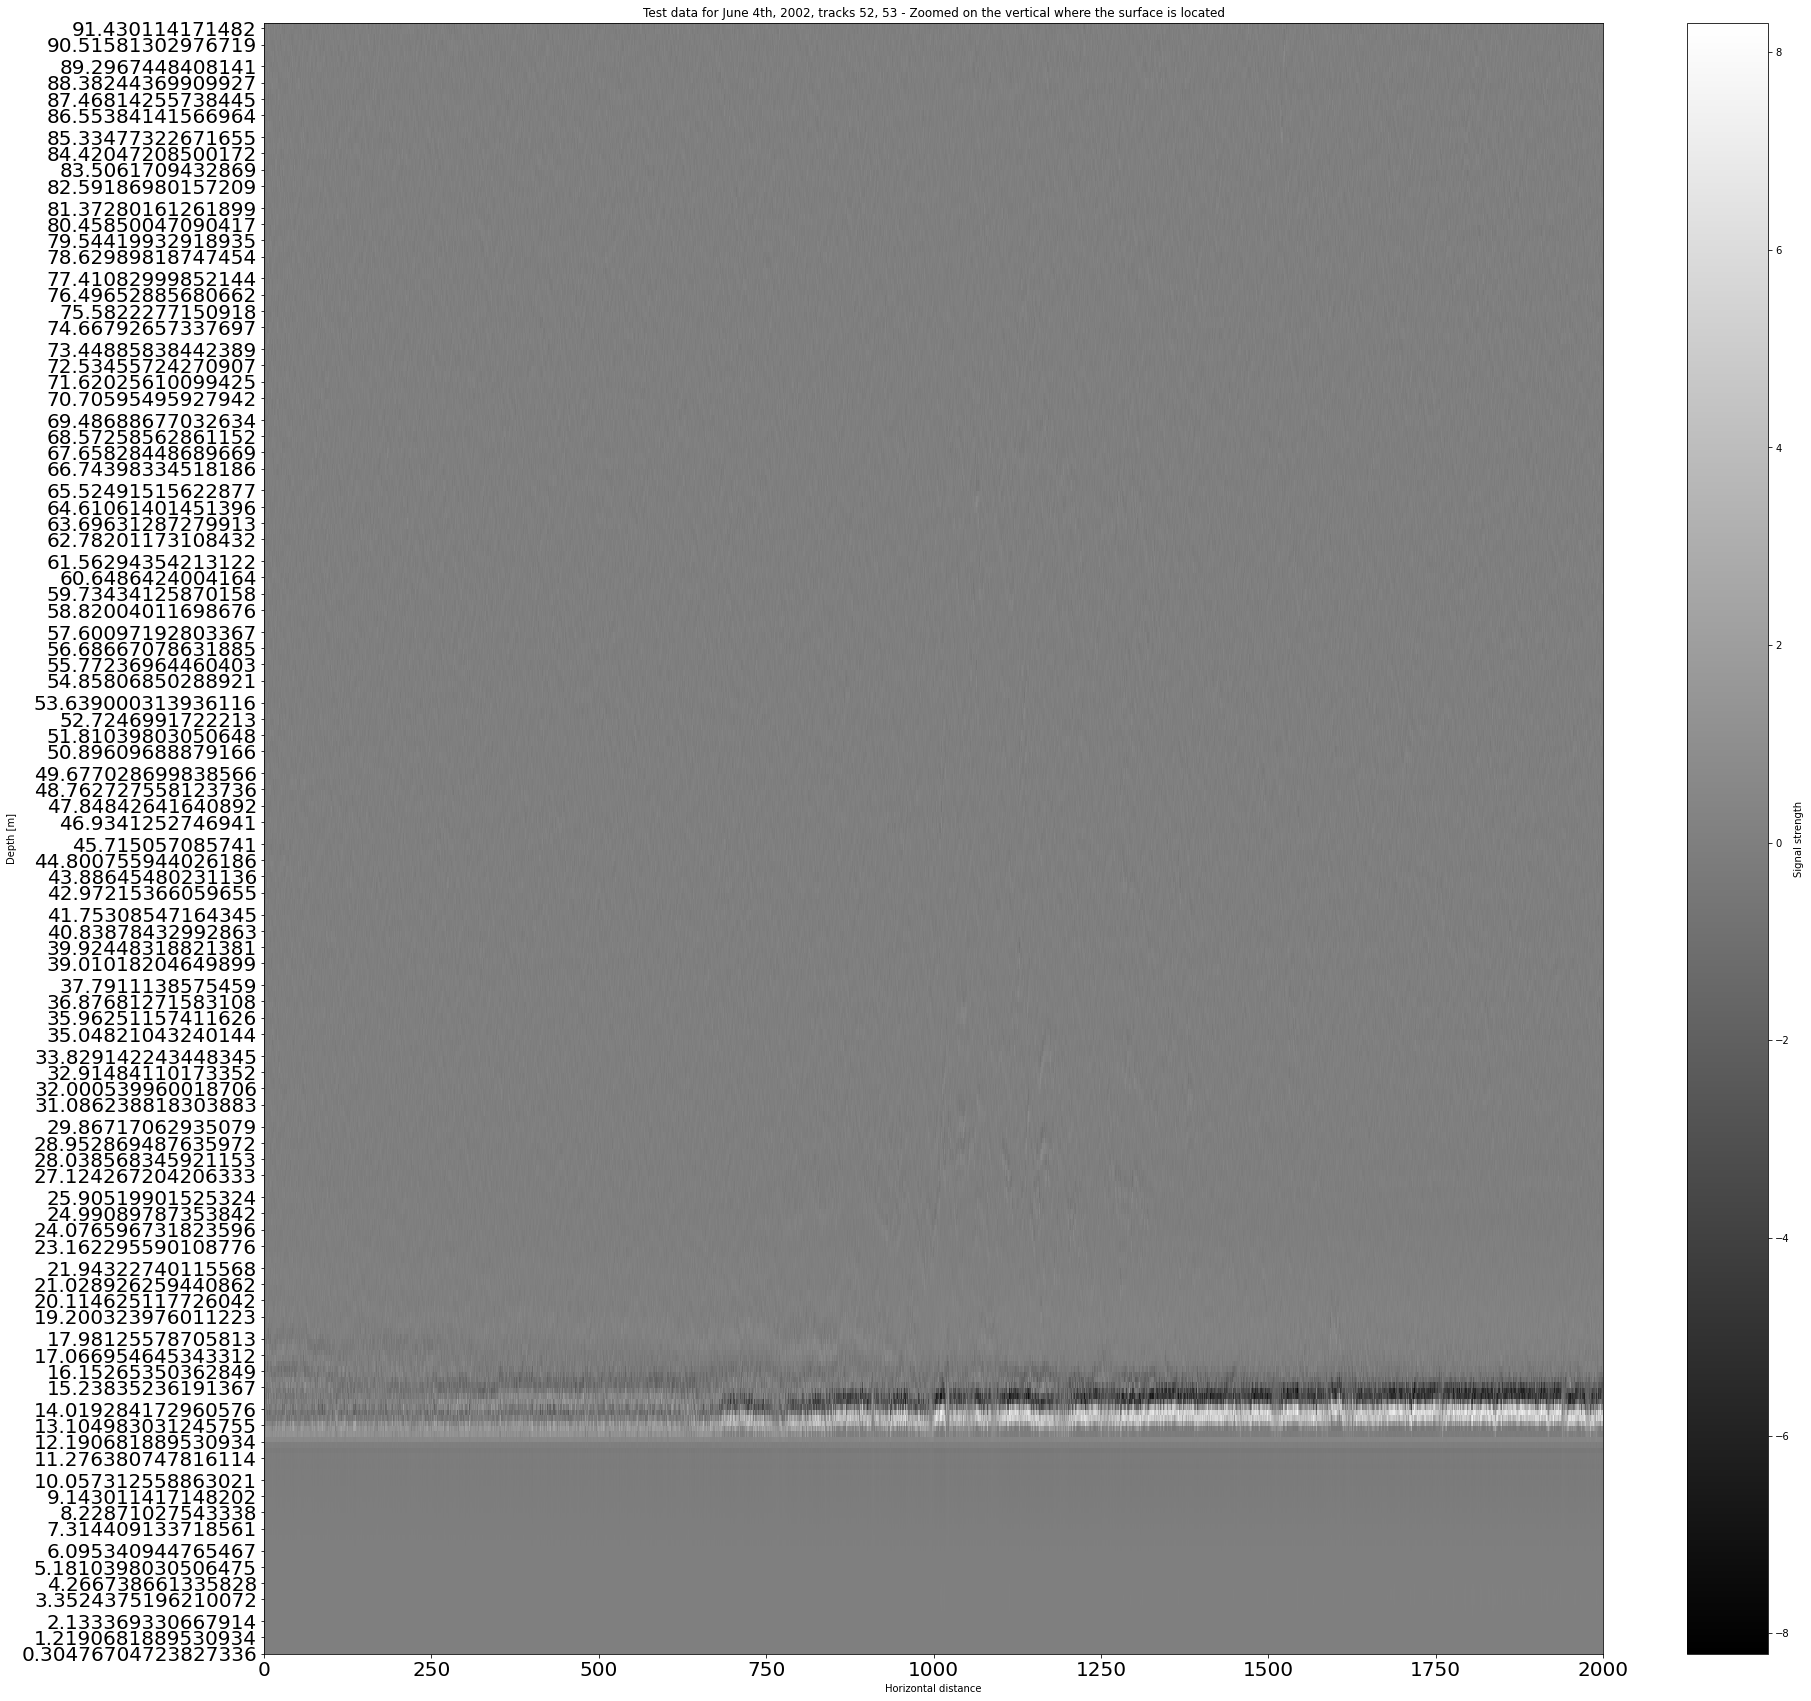

Additional informations: horizontal distance=[0,1000,2000] <=> elevation=[1951,1671,1361]


In [4]:
#Load a data
jun04_02proc_52= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//jun04_02proc_52.mat')
jun04_02proc_53= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//jun04_02proc_53.mat')

#Store the data into subdatasets
data_jun04_02proc_52=jun04_02proc_52['data']
lat_jun04_02proc_52=jun04_02proc_52['latitude']
lon_jun04_02proc_52=jun04_02proc_52['longitude']

data_jun04_02proc_53=jun04_02proc_53['data']
lat_jun04_02proc_53=jun04_02proc_53['latitude']
lon_jun04_02proc_53=jun04_02proc_53['longitude']


#Append June 4 2002 data:
data_jun04_02proc_52_53=np.append(data_jun04_02proc_52,data_jun04_02proc_53,axis=1)

#Filter the data for plotting
#data_jun04_02proc_52_53[abs(data_jun04_02proc_52_53)<0.005]=np.nan
#data_jun04_02proc_52_53[abs(data_jun04_02proc_52_53)>5]=np.nan
#data_jun04_02proc_52_53

#Time computation according to John Paden's email.
Nt = data_jun04_02proc_52_53.shape[0]
dt = 2.034489716724874e-09
t0 = 0; # Unknown so set to zero
Time = t0 + dt*np.arange(1,Nt+1)
Time
#Modified Robin speed:
# self.C / (1.0 + (coefficient*density_kg_m3/1000.0))
v= 299792458 / (1.0 + (0.734*0.873/1000.0))
#calculate the depth:
#self.SAMPLE_DEPTHS = self.radar_speed_m_s * self.SAMPLE_TIMES / 2.0
depths = v * Time / 2.0

ticks_yplot=np.around(np.linspace(0, 1400, 432))
ticks_yplot=ticks_yplot.astype(int)
labels_yplot=depths[ticks_yplot]

#Plot the data
pyplot.figure()
#Change the size of the figure
pyplot.rcParams["figure.figsize"]=30,30
color_map=pyplot.pcolor(data_jun04_02proc_52_53,cmap=pyplot.get_cmap('gray'))#,norm=divnorm)
pyplot.yticks(ticks=ticks_yplot,labels=labels_yplot)
pyplot.xticks(fontsize=20)
pyplot.yticks(fontsize=20)
pyplot.ylabel('Depth [m]')
pyplot.xlabel('Horizontal distance')
pyplot.ylim(0, 300)
pyplot.title('Test data for June 4th, 2002, tracks 52, 53 - Zoomed on the vertical where the surface is located')
cbar=pyplot.colorbar()
cbar.set_label('Signal strength')
pyplot.show()
# ---------
print('Additional informations: horizontal distance=[0,1000,2000] <=> elevation=[1951,1671,1361]')

The resolution for June 4th, 2002 looks quite poor

### 2.c. May 24, 2002, traces 4, 5

The dimensions of the data matrix is:
(4095, 1000)


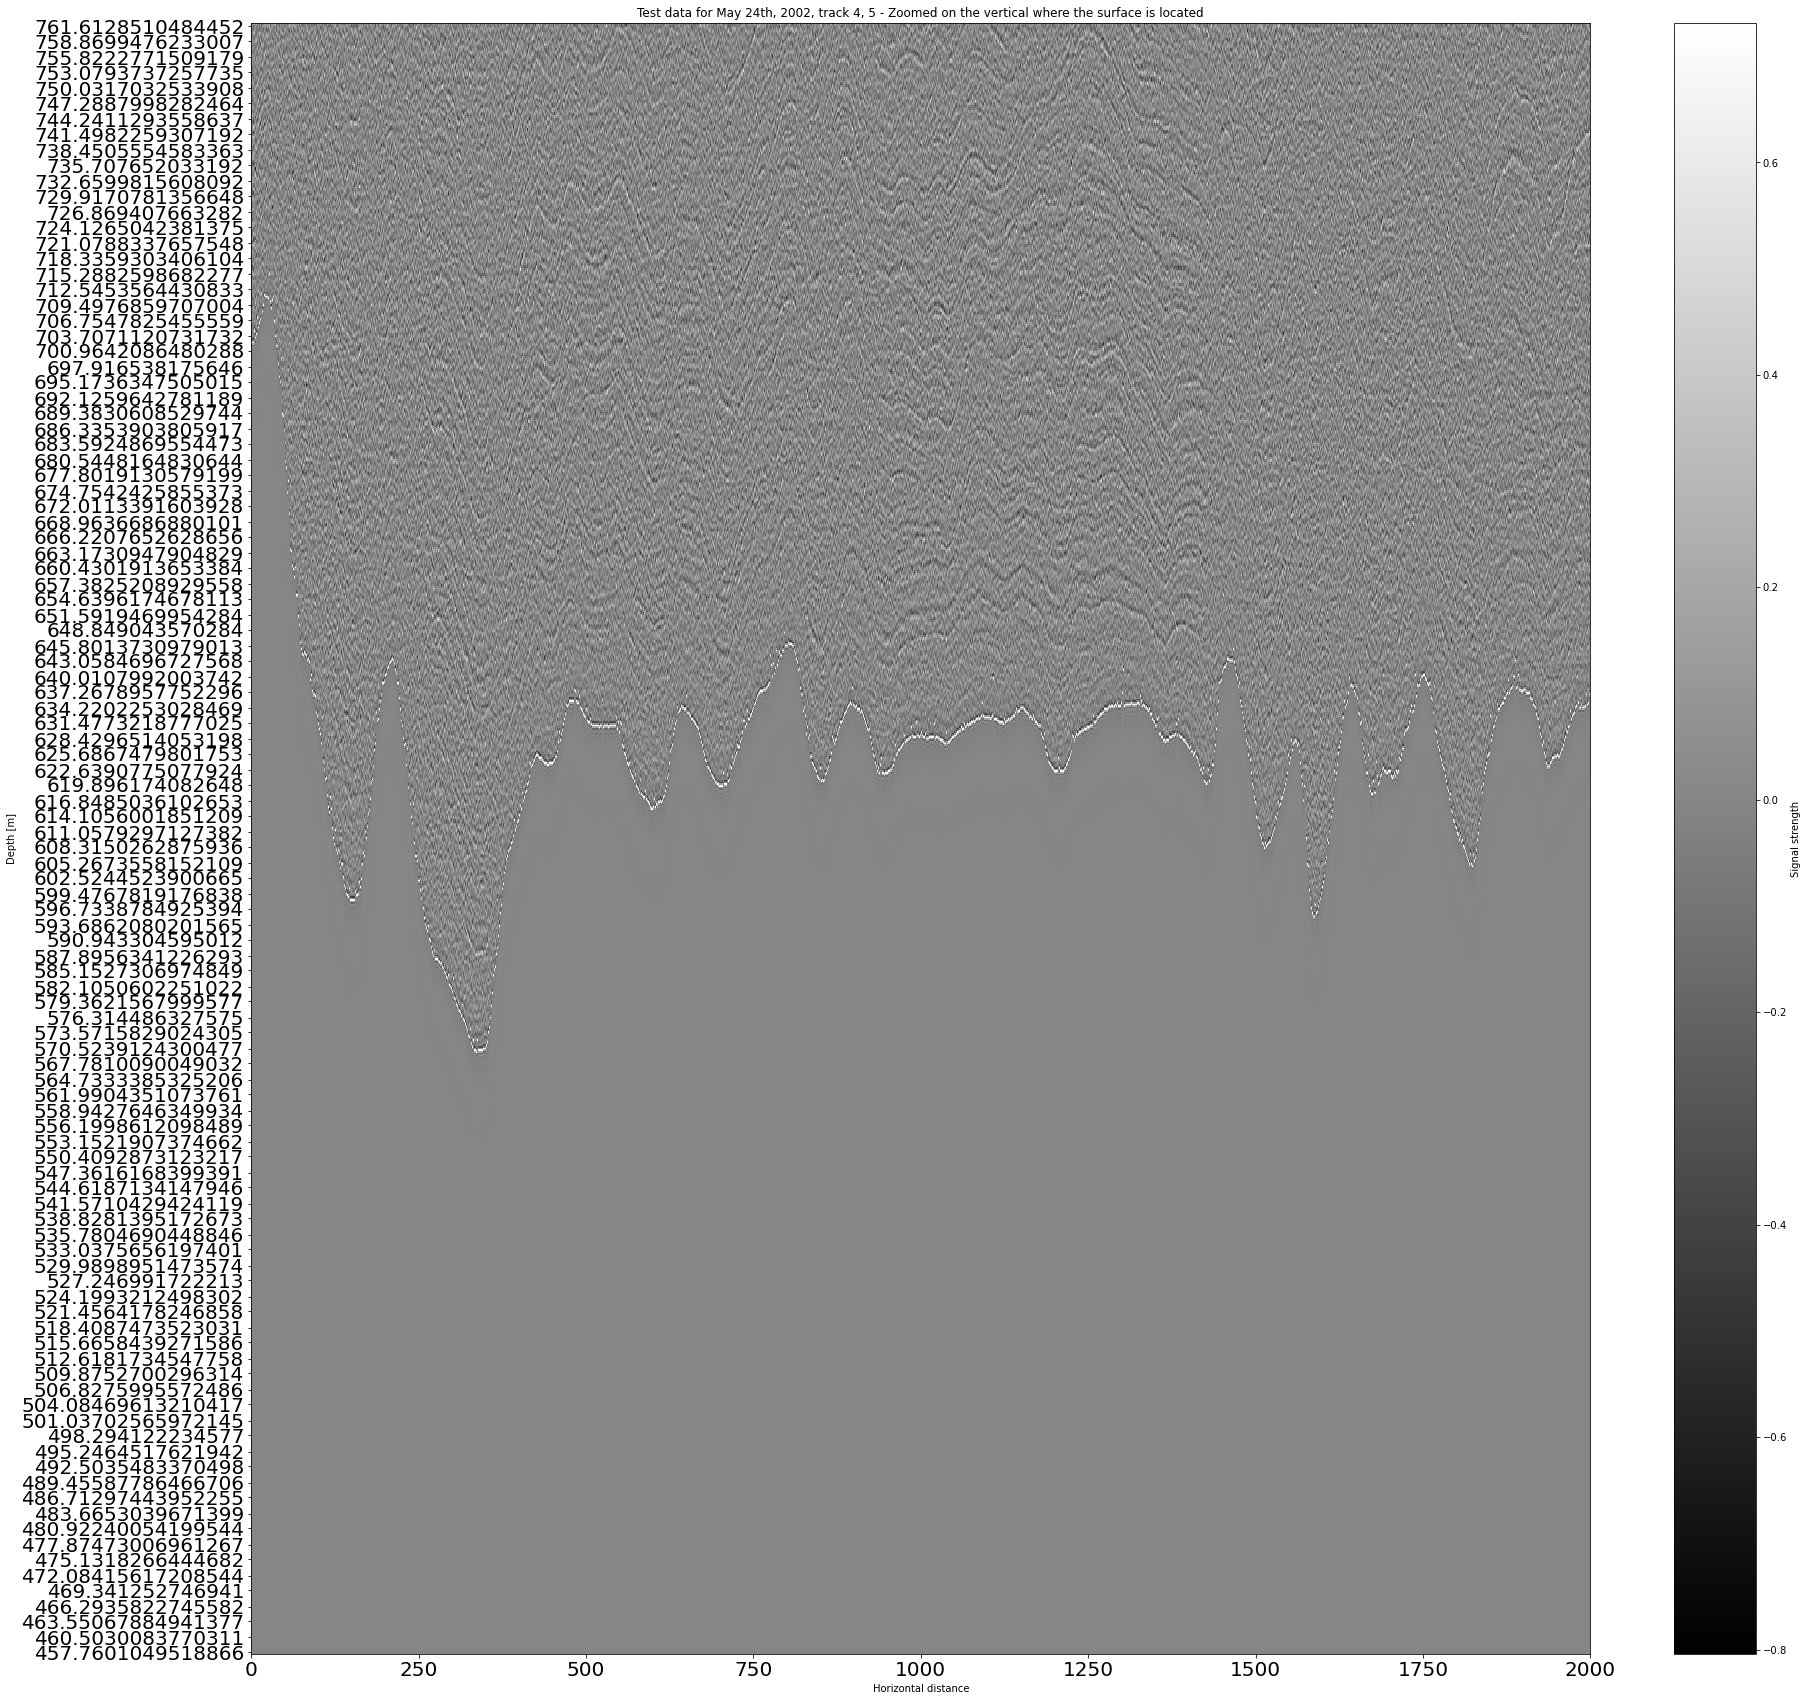

In [5]:
#may24_02_3= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_3.mat')
may24_02_4 = scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_4.mat')
may24_02_5 = scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_5.mat')


#Let's do a test with the variable 'filtfin', which is the only one who is a matrix
may24_02_4_filtfin=may24_02_4['filtfin']
may24_02_5_filtfin=may24_02_5['filtfin']

#Print the size of the subdatasets
print('The dimensions of the data matrix is:')
print(may24_02_4_filtfin.shape)

#Append June 4 2002 data:
data_may24_02_4_5=np.append(may24_02_4_filtfin,may24_02_5_filtfin,axis=1)


#Time computation according to John Paden's email.
Nt = data_may24_02_4_5.shape[0]
dt = 2.034489716724874e-09
t0 = 0; # Unknown so set to zero
Time = t0 + dt*np.arange(1,Nt+1)
Time
#Modified Robin speed:
# self.C / (1.0 + (coefficient*density_kg_m3/1000.0))
v= 299792458 / (1.0 + (0.734*0.873/1000.0))
#calculate the depth:
#self.SAMPLE_DEPTHS = self.radar_speed_m_s * self.SAMPLE_TIMES / 2.0
depths = v * Time / 2.0

ticks_yplot=np.around(np.linspace(0, 4094, 432))
ticks_yplot=ticks_yplot.astype(int)
labels_yplot=depths[ticks_yplot]


#Plot 
pyplot.figure()
#Change the size of the figure
pyplot.rcParams["figure.figsize"]=30,30
color_map=pyplot.pcolor(data_may24_02_4_5,cmap=pyplot.get_cmap('gray'))
pyplot.ylabel('Depth [m]')
pyplot.xlabel('Horizontal distance')
pyplot.yticks(ticks=ticks_yplot,labels=labels_yplot)
pyplot.xticks(fontsize=20)
pyplot.yticks(fontsize=20)
pyplot.ylim(1500, 2500)
pyplot.title('Test data for May 24th, 2002, track 4, 5 - Zoomed on the vertical where the surface is located')
cbar=pyplot.colorbar()
cbar.set_label('Signal strength')
pyplot.show()
# ---------

### 2.d Conclusions about 2002 datatset
- On both plots of June 4th, 2002: bright reflection in the ablation zone, then we start to see internal layering at elevation ~1500m, and we see these layers up to the end of the plot (evelation ~2355m). However, no clear evidence of ice slabs. How to calibrate these data for ice slabs identification??
- I do not miss the time varible anymore to retrieve the depth associated with the radar echo thanks to John Paden
- Even if poor resolution (especially on June 4th 2002), I might me able to see ice slabs if any. Maybe not access the thickness of individual ice slabs, but maybe enough to identify locations where they are.
- However, I miss the essential variable `Roll`: I might be able to have the aircraft roll from other sensors?
- I have a pdf file for quickly identify locations in which I am interested in only for June 4th

### => 2002 might be processable

### 3. Quicklook of 2003 data
### 3.a May 9th, 2003, trace n°1.This trace crosses and ice slabs region

We have two variables stored in it: filtfin, timearr


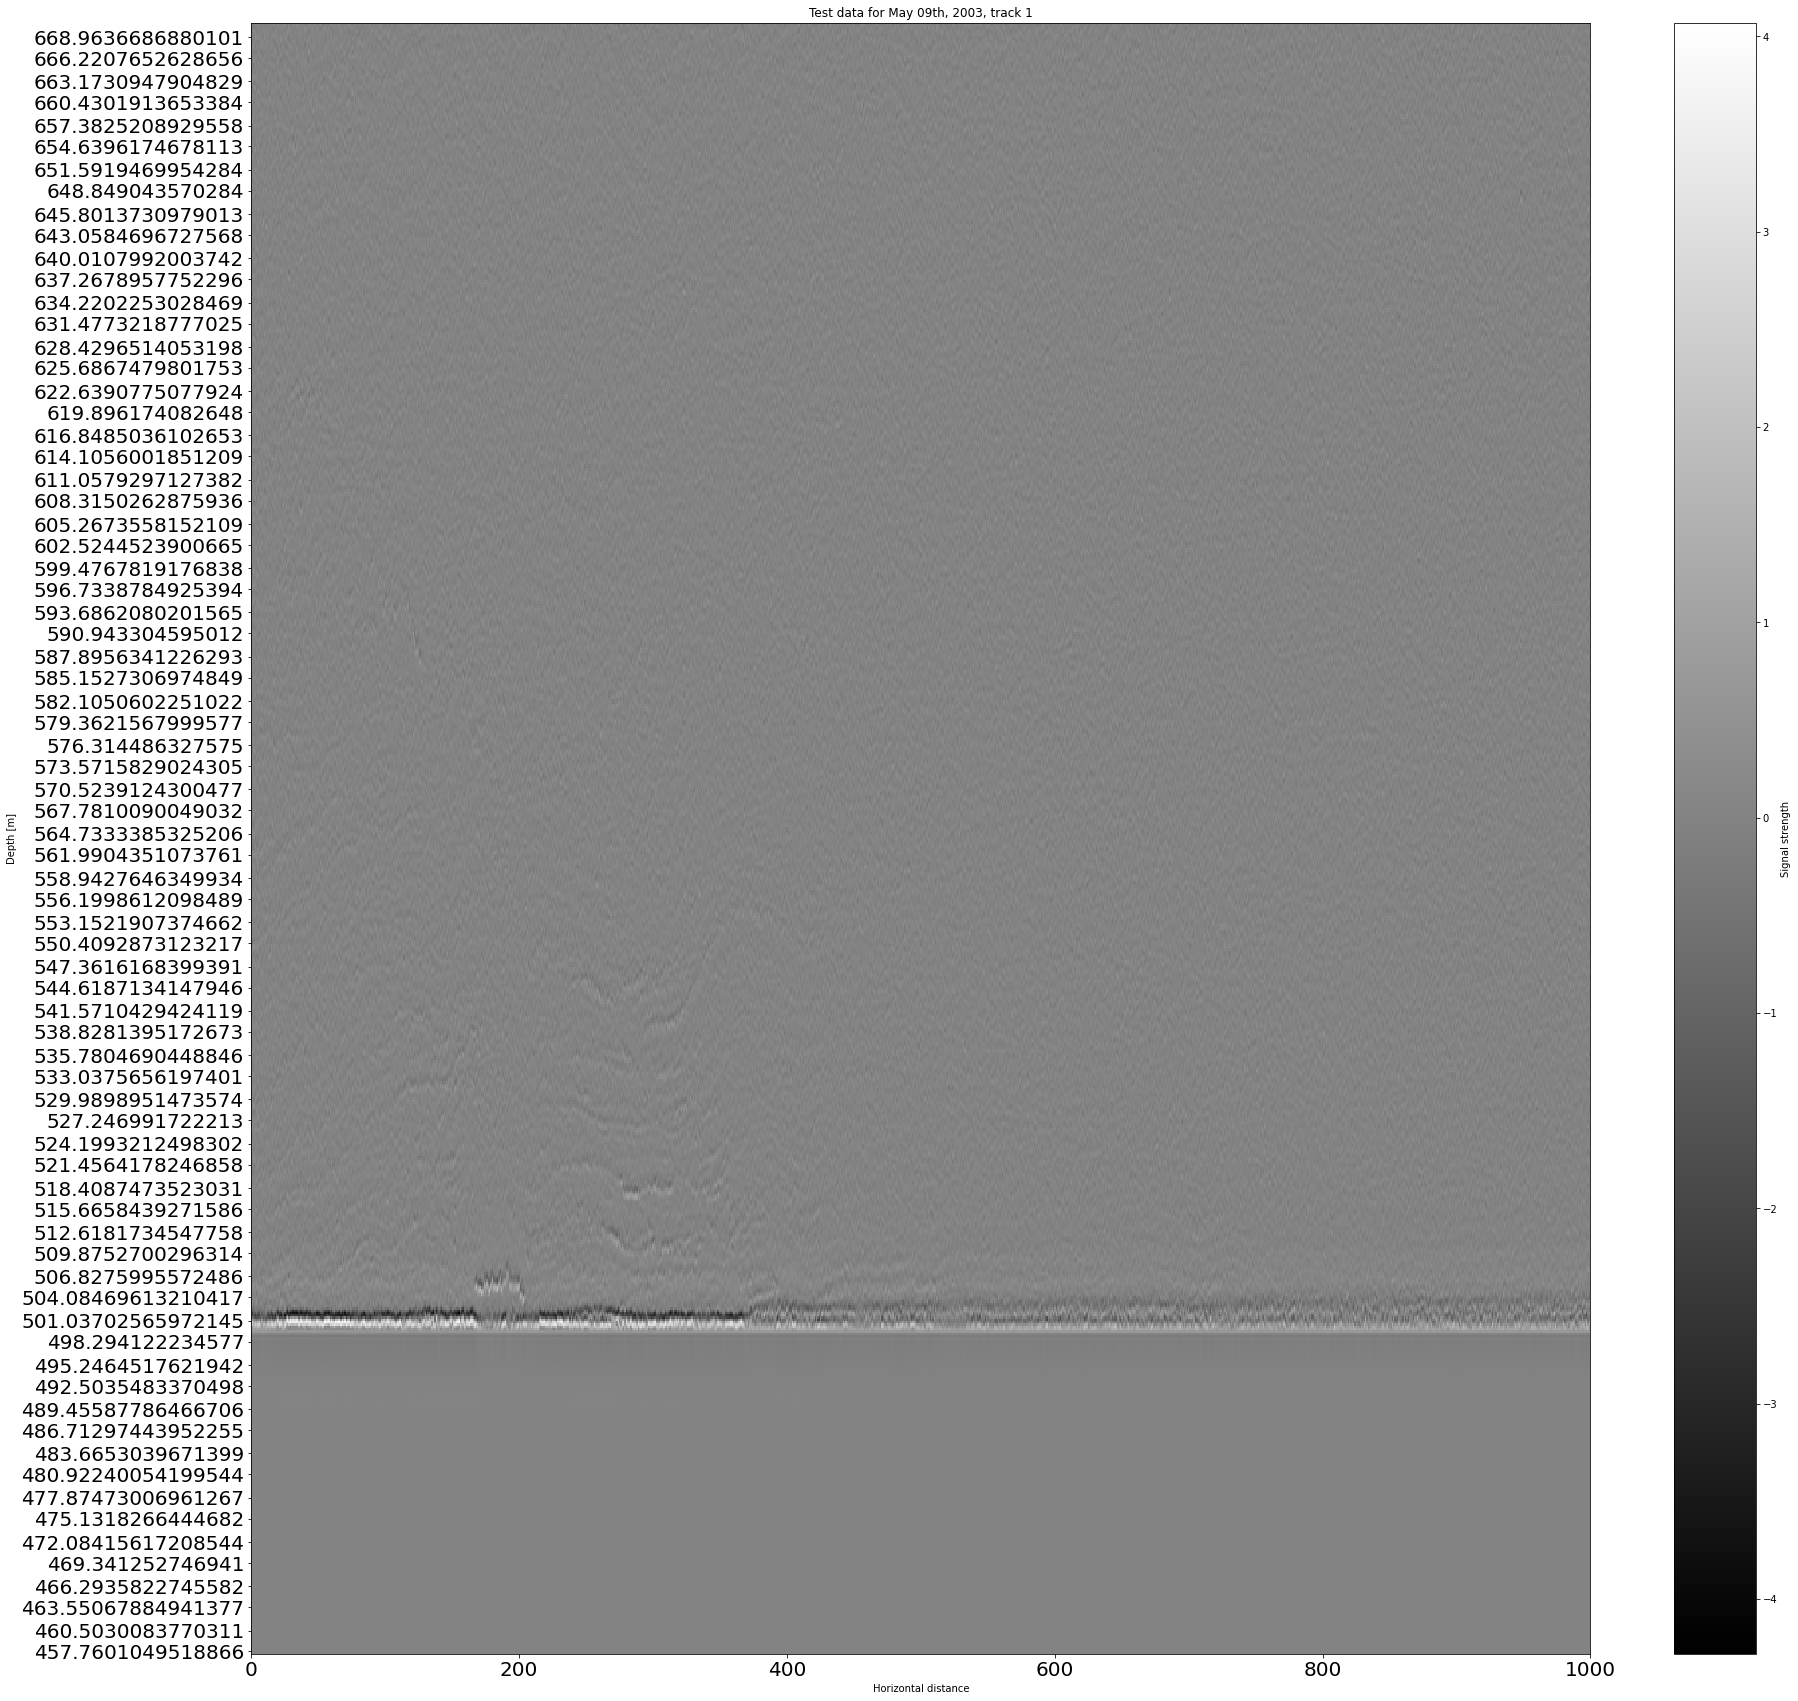

Additional informations: horizontal distance=[0,1000] <=> elevation=[1560,2015]


In [6]:
may09_03_1= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may09_03_1.mat')
print('We have two variables stored in it: filtfin, timearr')

#Let's do a test with the variable 'filtfin', which is the only one who is a matrix
may09_03_1_filtfin=may09_03_1['filtfin']
may09_03_1_timearr=may09_03_1['timearr']

#Time computation according to John Paden's email.
Nt = may09_03_1_filtfin.shape[0]
dt = 2.034489716724874e-09
t0 = 0; # Unknown so set to zero
Time = t0 + dt*np.arange(1,Nt+1)
Time
#Modified Robin speed:
# self.C / (1.0 + (coefficient*density_kg_m3/1000.0))
v= 299792458 / (1.0 + (0.734*0.873/1000.0))
#calculate the depth:
#self.SAMPLE_DEPTHS = self.radar_speed_m_s * self.SAMPLE_TIMES / 2.0
depths = v * Time / 2.0


ticks_yplot=np.around(np.linspace(0, 4094, 432))
ticks_yplot=ticks_yplot.astype(int)
labels_yplot=depths[ticks_yplot]


#Plot filtfin for trace 1
pyplot.figure()
#Change the size of the figure
pyplot.rcParams["figure.figsize"]=30,30
color_map=pyplot.pcolor(may09_03_1_filtfin,cmap=pyplot.get_cmap('gray'))
pyplot.ylabel('Depth [m]')
pyplot.xlabel('Horizontal distance')
pyplot.xticks(fontsize=20)
pyplot.yticks(fontsize=20)
pyplot.yticks(ticks=ticks_yplot,labels=labels_yplot)
pyplot.ylim(1500, 2200)
pyplot.title('Test data for May 09th, 2003, track 1')
cbar=pyplot.colorbar()
cbar.set_label('Signal strength')
pyplot.show()
# ---------

print('Additional informations: horizontal distance=[0,1000] <=> elevation=[1560,2015]')

### 3.b. May 12th, 2003, trace n°1 and 2. Trace 1 starts in the ablation zone, trace 2 has some part within the percolation zone and ends in the accumulation zone (at 2133m)

We have two variables stored in it: filtfin, timearr


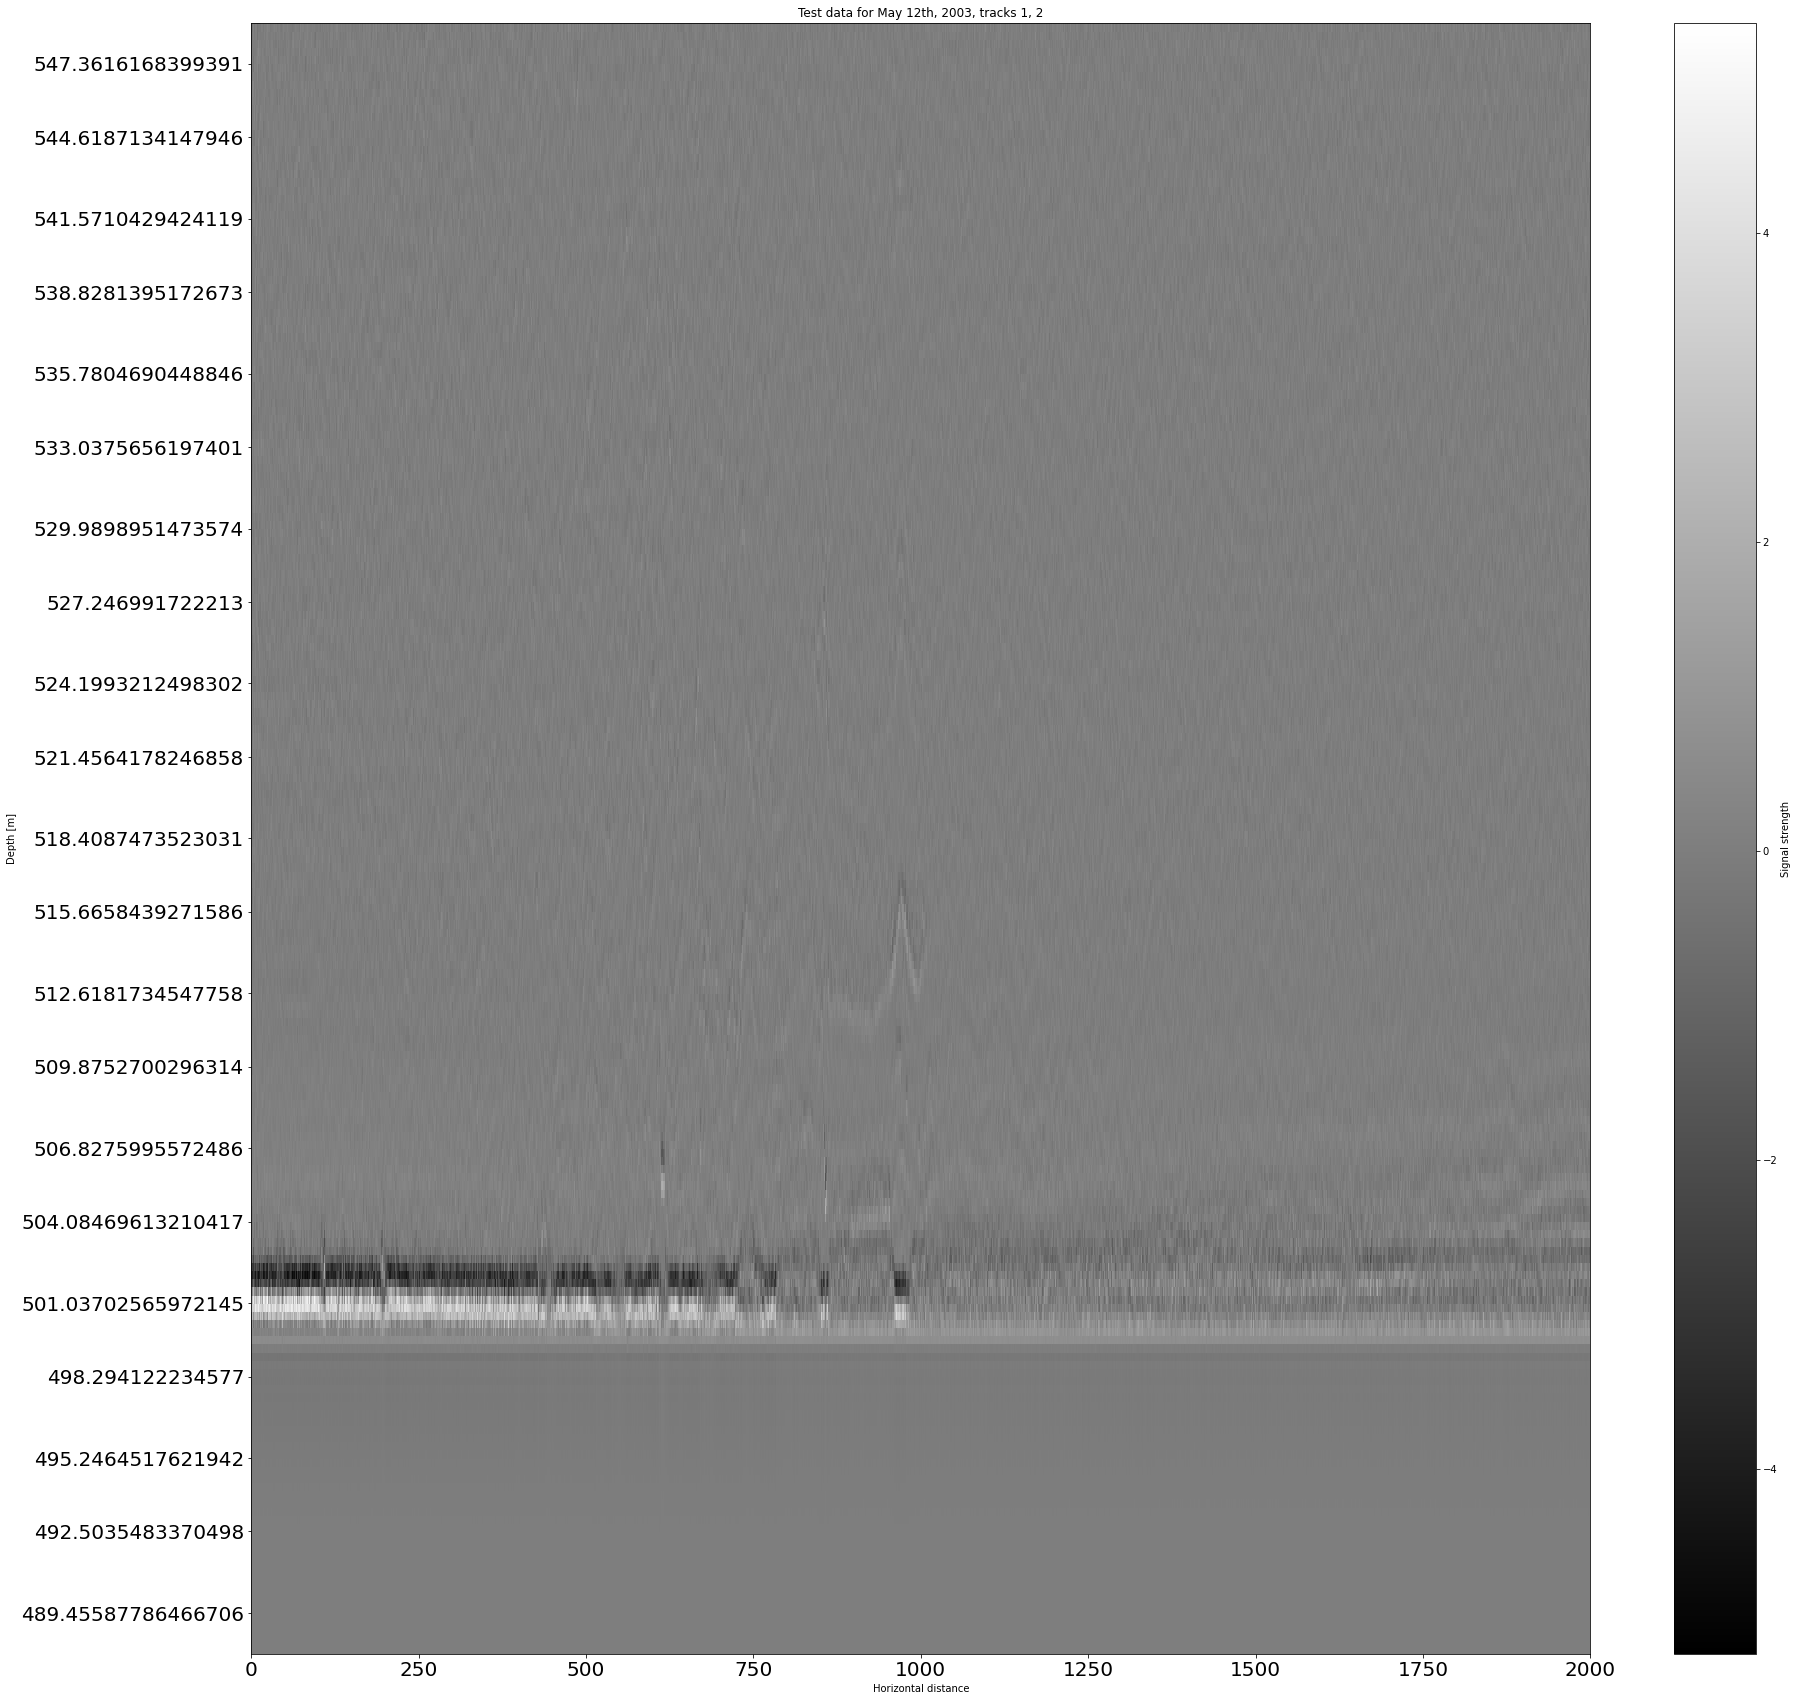

Additional informations: horizontal distance=[0,1000,2000] <=> elevation=[1286,1750,2131]


In [7]:
#Load a data
may12_03_1= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may12_03_1.mat')
may12_03_2= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may12_03_2.mat')
#may12_03_3= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may12_03_3.mat')

print('We have two variables stored in it: filtfin, timearr')
#Let's do a test with the variable 'filtfin', which is the only one who is a matrix
may12_03_1_filtfin=may12_03_1['filtfin']
may12_03_2_filtfin=may12_03_2['filtfin']
#may12_03_3_filtfin=may12_03_3['filtfin']

#Append data
may12_03_1_2=np.append(may12_03_1_filtfin,may12_03_2_filtfin,axis=1)
#may12_03_1_2_3=np.append(may12_03_1_2,may12_03_3_filtfin,axis=1)
#may12_03_1_2_3

#Time computation according to John Paden's email.
Nt = may12_03_1_2.shape[0]
dt = 2.034489716724874e-09
t0 = 0; # Unknown so set to zero
Time = t0 + dt*np.arange(1,Nt+1)
Time
#Modified Robin speed:
# self.C / (1.0 + (coefficient*density_kg_m3/1000.0))
v= 299792458 / (1.0 + (0.734*0.873/1000.0))
#calculate the depth:
#self.SAMPLE_DEPTHS = self.radar_speed_m_s * self.SAMPLE_TIMES / 2.0
depths = v * Time / 2.0


ticks_yplot=np.around(np.linspace(0, 4094, 432))
ticks_yplot=ticks_yplot.astype(int)
labels_yplot=depths[ticks_yplot]

# Plot data_jun04_02proc_3_4_5
pyplot.figure()
#Change the size of the figure
#pyplot.rcParams["figure.figsize"]=20,20
color_map=pyplot.pcolor(may12_03_1_2,cmap=pyplot.get_cmap('gray'))#,norm=divnorm)
pyplot.ylabel('Depth [m]')
pyplot.yticks(ticks=ticks_yplot,labels=labels_yplot)
pyplot.xlabel('Horizontal distance')
pyplot.xticks(fontsize=20)
pyplot.yticks(fontsize=20)
pyplot.ylim(1600, 1800)
#pyplot.yticks(ticks=pd.Series(np.arange(0,len(height_series),1)),labels=height_series)
pyplot.title('Test data for May 12th, 2003, tracks 1, 2')
cbar=pyplot.colorbar()
cbar.set_label('Signal strength')
pyplot.show()
# ---------
print('Additional informations: horizontal distance=[0,1000,2000] <=> elevation=[1286,1750,2131]')

### Conclusions about 2003 datatset
- On both plots of 2003, we cannot really see internal layering in the ablation zone. In the dry snow zone, we can see internal layers. We see a very interesting feature at around 1700m a.s.l. in both plots! Ice slabs? How to calibrate these data for ice slabs identification?? May 12 is a great example to investigate!
- I was able to recompute the time varibale thanks to John Paden's explanations, which allowed me to compute the depths associated with the radar echo.
- I might be able to see ice slabs if any. Not maybe access the thickness of individual ice slabs, but maybe enough to identify locations where they are.
- However, I miss the essential variable `Roll`: I might be able to have the aircraft roll from other sensors?
- I have a pdf file for quickly identify locations in which I am interested for any date in 2003

### => 2003 might be processable

# Appendix 1: Investigation on the 2002 and 2003 to find a correspondance between master and individual files to retreive the latitude and longitude of the tracks

As the 2017 dataset is working, there is no need to investiate on it further. Let's investigate what is inside the 2002 and 2003 datasets.

## 2002-2003 datasets
## I. 2002
### 1. Data and lenght of files 
### 1.a Summary

There are 4 dates of data: May 18, May 24, May 30, June 4 2002. In each of this folder of data, there are 2 types of datasets:
- `MMDD_YY_latlontime.map`
- `MMDD_YY_tracenb.mat`

The table below summarizes which variables are stored in each of these files, as well as the dimension of the variables:

| 2002 | 2002 | 2002 | 2002 | 2002 | 2002 | 2002 | 2002 | 2010 |
|------|------|------|------|------|------|------|------|------|
|   `may18_02_gps_latlontime.mat`   |   `may18_02_3.mat`    |   `may24_02_latlontime.mat`   |   `may24_02_3.mat`   |   `may30_02_latlontime.mat`   |   `may30_02_3.mat`   |   `jun04_02_latlontime.mat`   |   `jun04_02proc_3.mat`   | `Data_20100507_01_009.mat` |
| seconds (1, 39293)  |    /    | seconds (1, 35733)  |    /    | seconds (1, 58182) |     /     | seconds (1, 55636) |     /     | Time |
| lat_gps (1, 39293)  |    /    | lat_gps (1, 35733)  |    /    | lat_gps (1, 58182) |     /     | lat_gps (1, 55636) | latitude (1, 1000) | Latitude |
| lon_gps (1, 39293)  |    /    | lon_gps (1, 35733)  |    /    | lon_gps (1, 58182) |     /     | lon_gps (1, 55636) | longitude (1, 1000) | Longitude |
| alt_gps (1, 39293)  |    /    | elh (1, 35733)      |    /    | elh (1, 58182)     |     /     | elh  (1, 55636)    |     /     | Elevation |
|   /       |    /    |   /       |    /    |   /      |     /     |    /     |     /     |  Roll |
|   /       |    /    |   /       |    /    |   /      |     /     |    /     |     /     | Pitch |
|   /       |    /    |   /       |    /    |   /      |     /     |    /     |     /     | Heading |
| time_gps (1, 39293) |    /    | time_gps (1, 35733) |    /    | time_gps (1, 58182) |     /     | time_gps (1, 55636) |     /     | GPS_time |
|   /       |    /    |   /       |    /    |  /       |     /     |    /     |   <font color=blue> data (1401, 1000) </font>    | <font color=blue> Data </font> |
| useconds (1, 39293) |    /    | useconds (1, 35733) |    /    | useconds (1, 58182) |     /     | useconds (1, 55636) |     /     |  /  |
|   /       | <font color=blue> filtfin (4095, 1000)</font> |   /       | <font color=blue> filtfin (4095, 1000) </font> |   /      |  <font color=blue> filtfin (4095, 1000) </font>  |    /     |     /     |   /   |
|   /       | timearr (1, 1000) |   /       | timearr (1, 1000) |   /      |  timearr (1, 1000) |    /     |     /     |   /   |
|   /       |    /    |   /       |    /    |   /      |     /     |    /     |     /     | And other parameters |

Problem: there not seems to be a time variable associated with the data to allow me for retreiving the depth of the echogram. I need a time variable lenght to be equal to 4095. No such variable exsit. I am thus having a look at the variables that have a time dimension: maybe the time variable of any trace have been appended one after each other in a variable. Thus, I am need to:
1. Pick up a date and sum the length of the of the depths of any trace to know the total sum of this hypothetical time variable
2. Look into the any variable that have a time dimension in the corresponding `MMDD_YY_latlontime.mat` file

### 1.b Let's choose the date May 24 2002

In [8]:
#load individual data
may24_02_0= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_0.mat')
may24_02_1= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_1.mat')
may24_02_2= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_2.mat')
may24_02_3= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_3.mat')
may24_02_4= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_4.mat')
may24_02_5= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_5.mat')
may24_02_6= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_6.mat')
may24_02_7= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_7.mat')
may24_02_8= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_8.mat')
may24_02_9= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_9.mat')
may24_02_10= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_10.mat')
may24_02_11= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_11.mat')
may24_02_12= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_12.mat')
may24_02_13= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_13.mat')
may24_02_14= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_14.mat')
may24_02_15= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_15.mat')
may24_02_16= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_16.mat')
may24_02_17= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_17.mat')
may24_02_18= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_18.mat')
may24_02_19= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_19.mat')
may24_02_20= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_20.mat')
may24_02_21= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_21.mat')
may24_02_22= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_22.mat')
may24_02_23= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_23.mat')
may24_02_24= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_24.mat')
may24_02_25= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_25.mat')

#store the filtfin to obtain the length of the depth
may24_02_0_filtfin= may24_02_0['filtfin']
may24_02_1_filtfin= may24_02_1['filtfin']
may24_02_2_filtfin= may24_02_2['filtfin']
may24_02_3_filtfin= may24_02_3['filtfin']
may24_02_4_filtfin= may24_02_4['filtfin']
may24_02_5_filtfin= may24_02_5['filtfin']
may24_02_6_filtfin= may24_02_6['filtfin']
may24_02_7_filtfin= may24_02_7['filtfin']
may24_02_8_filtfin= may24_02_8['filtfin']
may24_02_9_filtfin= may24_02_9['filtfin']
may24_02_10_filtfin= may24_02_10['filtfin']
may24_02_11_filtfin= may24_02_11['filtfin']
may24_02_12_filtfin= may24_02_12['filtfin']
may24_02_13_filtfin= may24_02_13['filtfin']
may24_02_14_filtfin= may24_02_14['filtfin']
may24_02_15_filtfin= may24_02_15['filtfin']
may24_02_16_filtfin= may24_02_16['filtfin']
may24_02_17_filtfin= may24_02_17['filtfin']
may24_02_18_filtfin= may24_02_18['filtfin']
may24_02_19_filtfin= may24_02_19['filtfin']
may24_02_20_filtfin= may24_02_20['filtfin']
may24_02_21_filtfin= may24_02_21['filtfin']
may24_02_22_filtfin= may24_02_22['filtfin']
may24_02_23_filtfin= may24_02_23['filtfin']
may24_02_24_filtfin= may24_02_24['filtfin']
may24_02_25_filtfin= may24_02_25['filtfin']

#store the timearr to obtain the length of the timearr variable
may24_02_0_timearr= may24_02_0['timearr']

#Load the gps latlontime file for May 24 2002
may24_02_gpslatlontime= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_latlontime.mat')

#Print the sum of the shapes
print('The sum of the depths for all files in May 24 2002 is:')
print(may24_02_0_filtfin.shape[0]+may24_02_1_filtfin.shape[0]+may24_02_2_filtfin.shape[0]+may24_02_3_filtfin.shape[0]+may24_02_4_filtfin.shape[0]+may24_02_5_filtfin.shape[0]+may24_02_6_filtfin.shape[0]+may24_02_7_filtfin.shape[0]+may24_02_8_filtfin.shape[0]+may24_02_9_filtfin.shape[0]+may24_02_10_filtfin.shape[0]+may24_02_11_filtfin.shape[0]+may24_02_12_filtfin.shape[0]+may24_02_13_filtfin.shape[0]+may24_02_14_filtfin.shape[0]+may24_02_15_filtfin.shape[0]+may24_02_16_filtfin.shape[0]+may24_02_17_filtfin.shape[0]+may24_02_18_filtfin.shape[0]+may24_02_19_filtfin.shape[0]+may24_02_20_filtfin.shape[0]+may24_02_21_filtfin.shape[0]+may24_02_22_filtfin.shape[0]+may24_02_23_filtfin.shape[0]+may24_02_24_filtfin.shape[0]+may24_02_25_filtfin.shape[0])
print('The sum of the horizontal distance for all files in May 24 2002 is:')
print(may24_02_0_filtfin.shape[1]+may24_02_1_filtfin.shape[1]+may24_02_2_filtfin.shape[1]+may24_02_3_filtfin.shape[1]+may24_02_4_filtfin.shape[1]+may24_02_5_filtfin.shape[1]+may24_02_6_filtfin.shape[1]+may24_02_7_filtfin.shape[1]+may24_02_8_filtfin.shape[1]+may24_02_9_filtfin.shape[1]+may24_02_10_filtfin.shape[1]+may24_02_11_filtfin.shape[1]+may24_02_12_filtfin.shape[1]+may24_02_13_filtfin.shape[1]+may24_02_14_filtfin.shape[1]+may24_02_15_filtfin.shape[1]+may24_02_16_filtfin.shape[1]+may24_02_17_filtfin.shape[1]+may24_02_18_filtfin.shape[1]+may24_02_19_filtfin.shape[1]+may24_02_20_filtfin.shape[1]+may24_02_21_filtfin.shape[1]+may24_02_22_filtfin.shape[1]+may24_02_23_filtfin.shape[1]+may24_02_24_filtfin.shape[1]+may24_02_25_filtfin.shape[1])
#Print file characteristics

print('Dimension of the seconds variable in the file may24_02_gpslatlontime.mat')
print(may24_02_gpslatlontime['seconds'].shape)
print('Dimension of the useconds variable in the file may24_02_gpslatlontime.mat')
print(may24_02_gpslatlontime['useconds'].shape)
print('Dimension of the time_gps variable in the file may24_02_gpslatlontime.mat')
print(may24_02_gpslatlontime['time_gps'].shape)
print('Dimension of the latitude variable in the file may24_02_gpslatlontime.mat')
print(may24_02_gpslatlontime['lat_gps'].shape)
print('Dimension of the time_gps variable in the file may24_02_gpslatlontime.mat')
print(may24_02_gpslatlontime['lon_gps'].shape)
print(' ')
print('The size of the timearr (from individual track file) is:')
print(may24_02_0_timearr.shape)
print('The size of the filtfin (from individual track file) is:')
print(may24_02_0_filtfin.shape)

The sum of the depths for all files in May 24 2002 is:
106470
The sum of the horizontal distance for all files in May 24 2002 is:
26000
Dimension of the seconds variable in the file may24_02_gpslatlontime.mat
(1, 35733)
Dimension of the useconds variable in the file may24_02_gpslatlontime.mat
(1, 35733)
Dimension of the time_gps variable in the file may24_02_gpslatlontime.mat
(1, 35733)
Dimension of the latitude variable in the file may24_02_gpslatlontime.mat
(1, 35733)
Dimension of the time_gps variable in the file may24_02_gpslatlontime.mat
(1, 35733)
 
The size of the timearr (from individual track file) is:
(1, 1000)
The size of the filtfin (from individual track file) is:
(4095, 1000)


### The sum of the depth for all files if 106'470 != 35'733. The time variable associated with the radar echogram is not present for 2002 dataset, except for June 4th 2002.
### 1.c Let's have a look at the variables stored in the master files anyway to see if we cannot extract anything still.
1. `[time_gps]` variable

For Jun 04 2002, we have six variables stored in it: seconds, useconds, lat_gps, lon_gps, elh, time_gps
For May 18 2002, we have six variables stored in it: seconds, useconds, lat_gps, lon_gps, alt_gps, time_gps
For May 24 2002, we have six variables stored in it: seconds, useconds, lat_gps, lon_gps, elh, time_gps
For May 30 2002, we have six variables stored in it: seconds, useconds, lat_gps, lon_gps, elh, time_gps
 
The length of the gps time vector for May 18 is: 39293
The length of the gps time vector for May 24 is: 35733
The length of the gps time vector for May 30 is: 58182
The length of the gps time vector for Jun 04 is: 55636


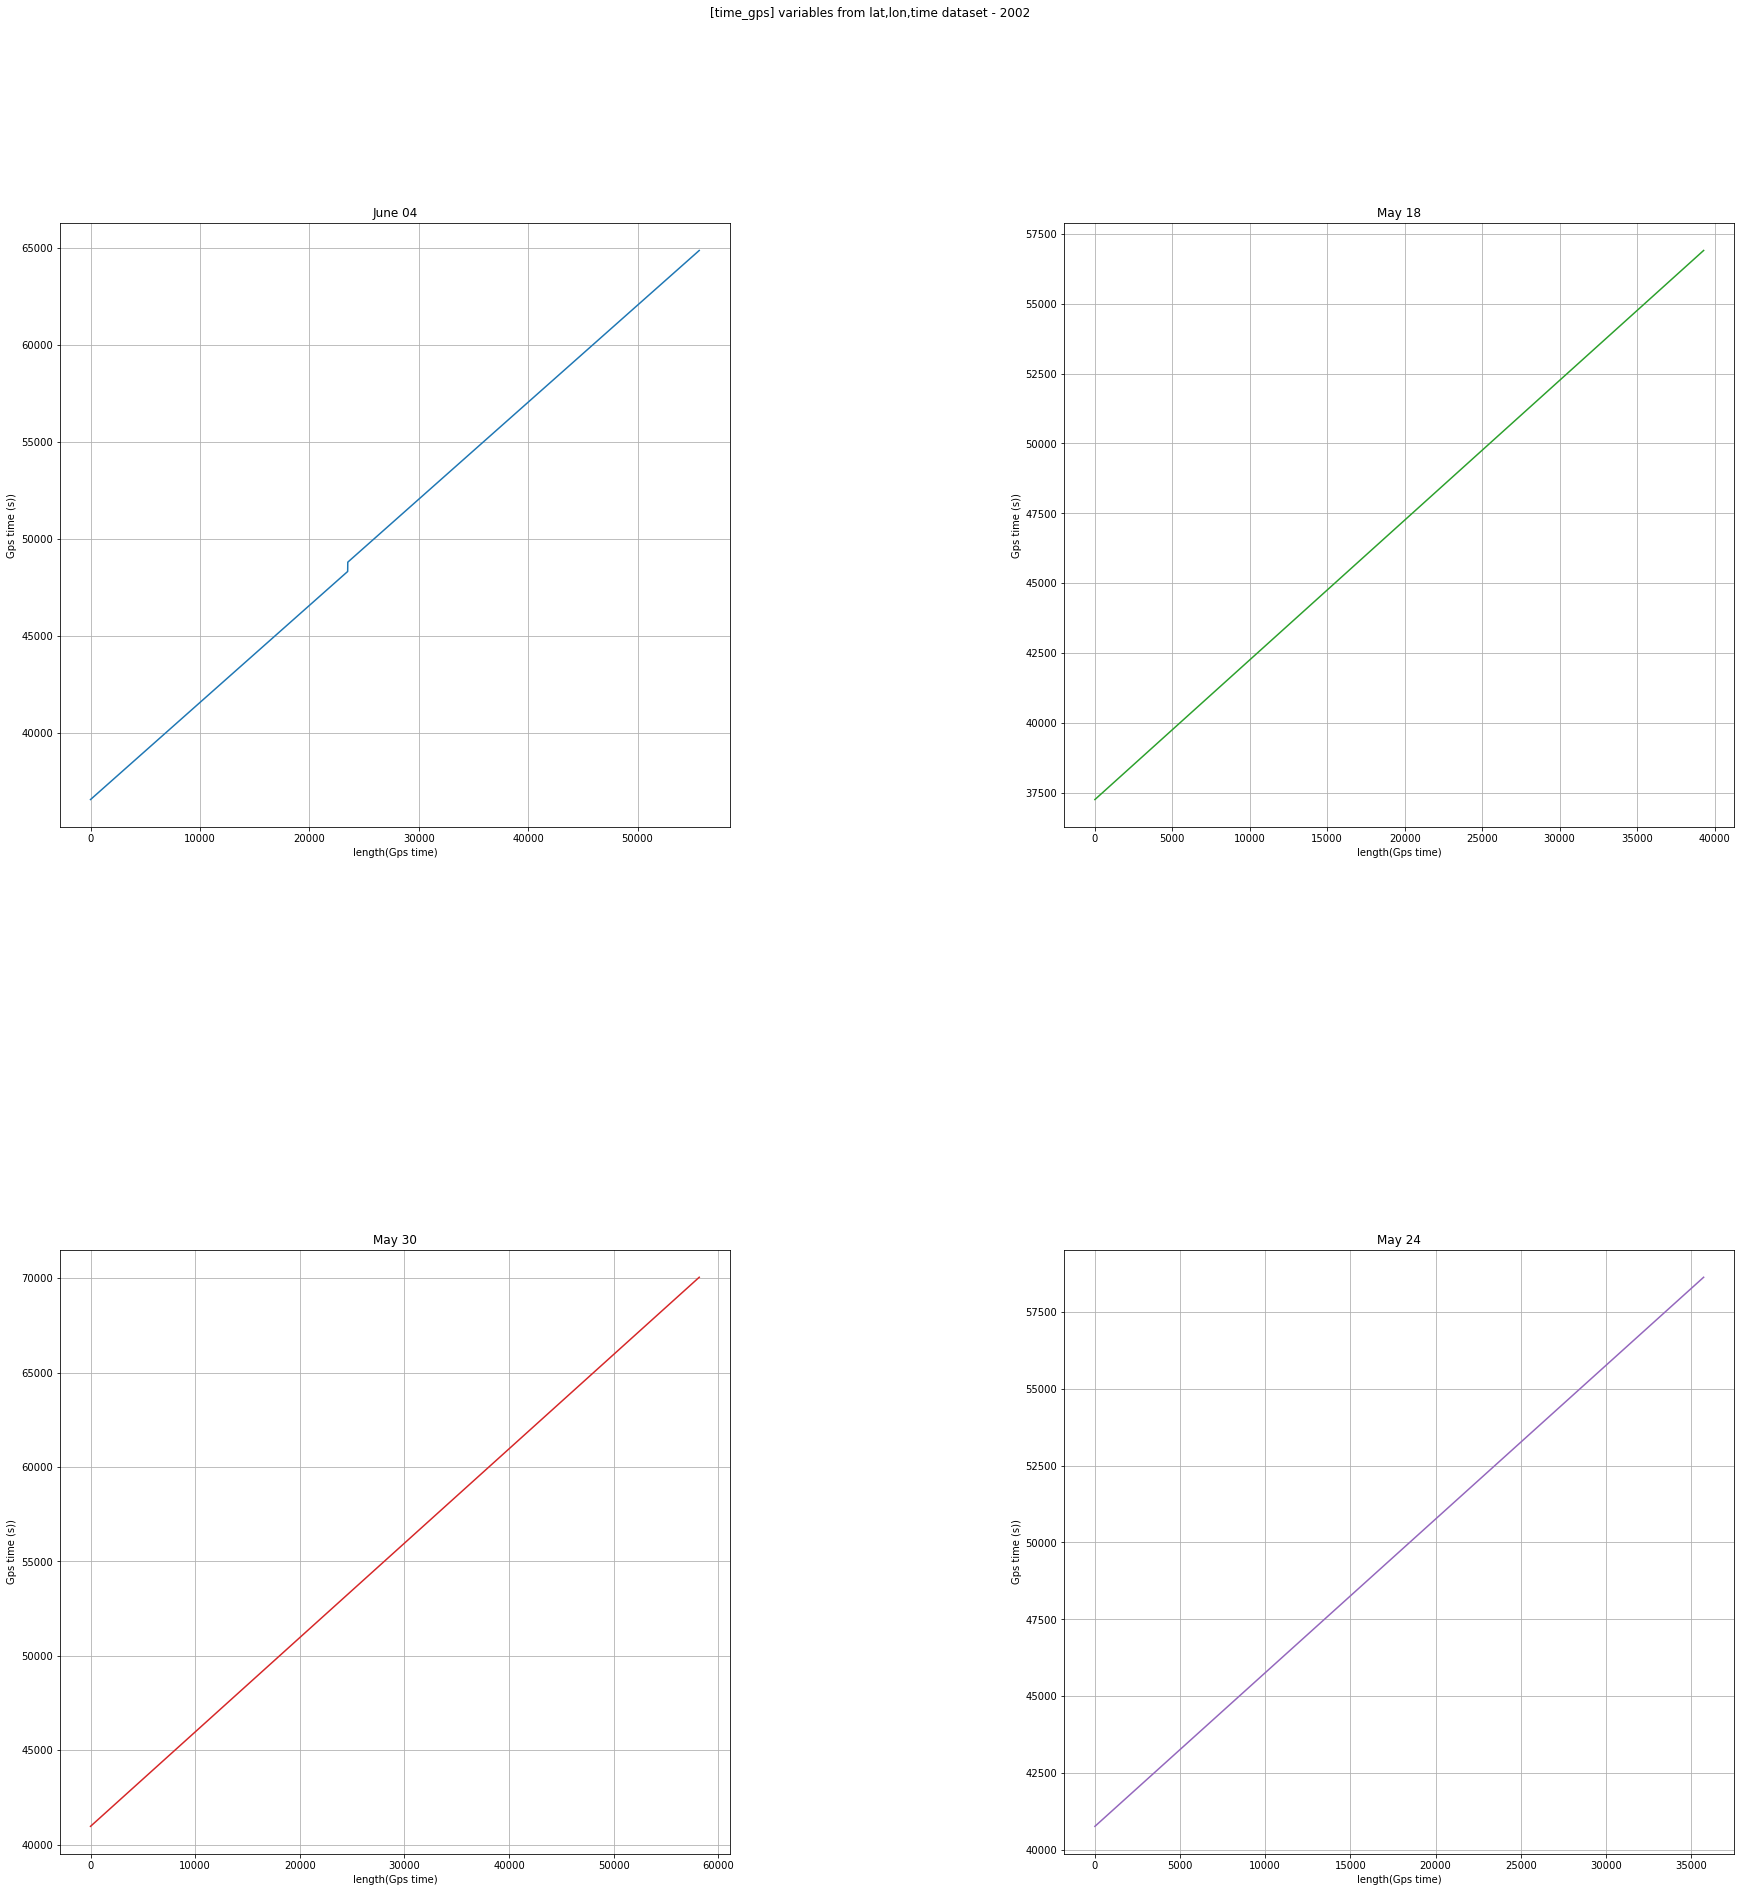

In [9]:
#Load lat,lon data
june04_2002 = scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//jun04_02_latlontime.mat')
may18_2002 = scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may18_02_gps_latlontime.mat')
may24_2002 = scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may24_02_latlontime.mat')
may30_2002 = scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2002//may30_02_latlontime.mat')

#print(june04_2002)
print('For Jun 04 2002, we have six variables stored in it: seconds, useconds, lat_gps, lon_gps, elh, time_gps')

#print(may18_2002)
print('For May 18 2002, we have six variables stored in it: seconds, useconds, lat_gps, lon_gps, alt_gps, time_gps')

#print(may24_2002)
print('For May 24 2002, we have six variables stored in it: seconds, useconds, lat_gps, lon_gps, elh, time_gps')

#print(may30_2002)
print('For May 30 2002, we have six variables stored in it: seconds, useconds, lat_gps, lon_gps, elh, time_gps')
print(' ')

#Store data for june 04 in different vectors
june04_sec=june04_2002['seconds']
june04_usec=june04_2002['useconds']
june04_lat_gps=june04_2002['lat_gps']
june04_lon_gps=june04_2002['lon_gps']
june04_elhh=june04_2002['elh']
june04_time_gps=june04_2002['time_gps']

#Store time data
june04_time_gps=june04_2002['time_gps']
may18_time_gps=may18_2002['time_gps']
may24_time_gps=may24_2002['time_gps']
may30_time_gps=may30_2002['time_gps']

#Print the lengths of the gps times
print('The length of the gps time vector for May 18 is: ' + str(may18_time_gps.shape[1]))
print('The length of the gps time vector for May 24 is: ' + str(may24_time_gps.shape[1]))
print('The length of the gps time vector for May 30 is: ' + str(may30_time_gps.shape[1]))
print('The length of the gps time vector for Jun 04 is: ' + str(june04_time_gps.shape[1]))

#Create the x vector to plot
x_vec_june04=june04_time_gps[:1]
x_june04=np.arange(x_vec_june04.size)

x_vec_may18=may18_time_gps[:1]
x_may18=np.arange(x_vec_may18.size)

x_vec_may24=may24_time_gps[:1]
x_may24=np.arange(x_vec_may24.size)

x_vec_may30=may30_time_gps[:1]
x_may30=np.arange(x_vec_may30.size)

#Plot the GPS time
fig, axs = pyplot.subplots(2, 2)
axs[0, 0].plot(x_june04,june04_time_gps.reshape((x_vec_june04.size,)),'tab:blue')
axs[0, 0].set_title('June 04')
axs[0, 0].grid()
axs[0, 1].plot(x_may18,may18_time_gps.reshape((x_vec_may18.size,)), 'tab:green')
axs[0, 1].set_title('May 18')
axs[0, 1].grid()
axs[1, 0].plot(x_may30,may30_time_gps.reshape((x_vec_may30.size,)), 'tab:red')
axs[1, 0].set_title('May 30')
axs[1, 0].grid()
axs[1, 1].plot(x_may24,may24_time_gps.reshape((x_vec_may24.size,)), 'tab:purple')
axs[1, 1].set_title('May 24')
axs[1, 1].grid()

fig.suptitle('[time_gps] variables from lat,lon,time dataset - 2002')

for ax in axs.flat:
    ax.set(xlabel='length(Gps time)', ylabel='Gps time (s))')

pyplot.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.7)

I thought in a first place that the GPS time given in the lat_lon_time dataset was maybe the time related to the signal penetration, each time array related to each subtrack being aggregated into a big array. However, because the GPS time is increasing linearly, it means this is not the time related to the signal penetration (otherwise I would have seen increase related to the signal penetration depth, then go back to a value that correpsonds to the surface and increasing lineraly and do on).

2. `[seconds]` variable

The length of the seconds vector for May 18 is: 39293
The length of the seconds vector for May 24 is: 35733
The length of the seconds vector for May 30 is: 58182
The length of the seconds vector for Jun 04 is: 55636
 


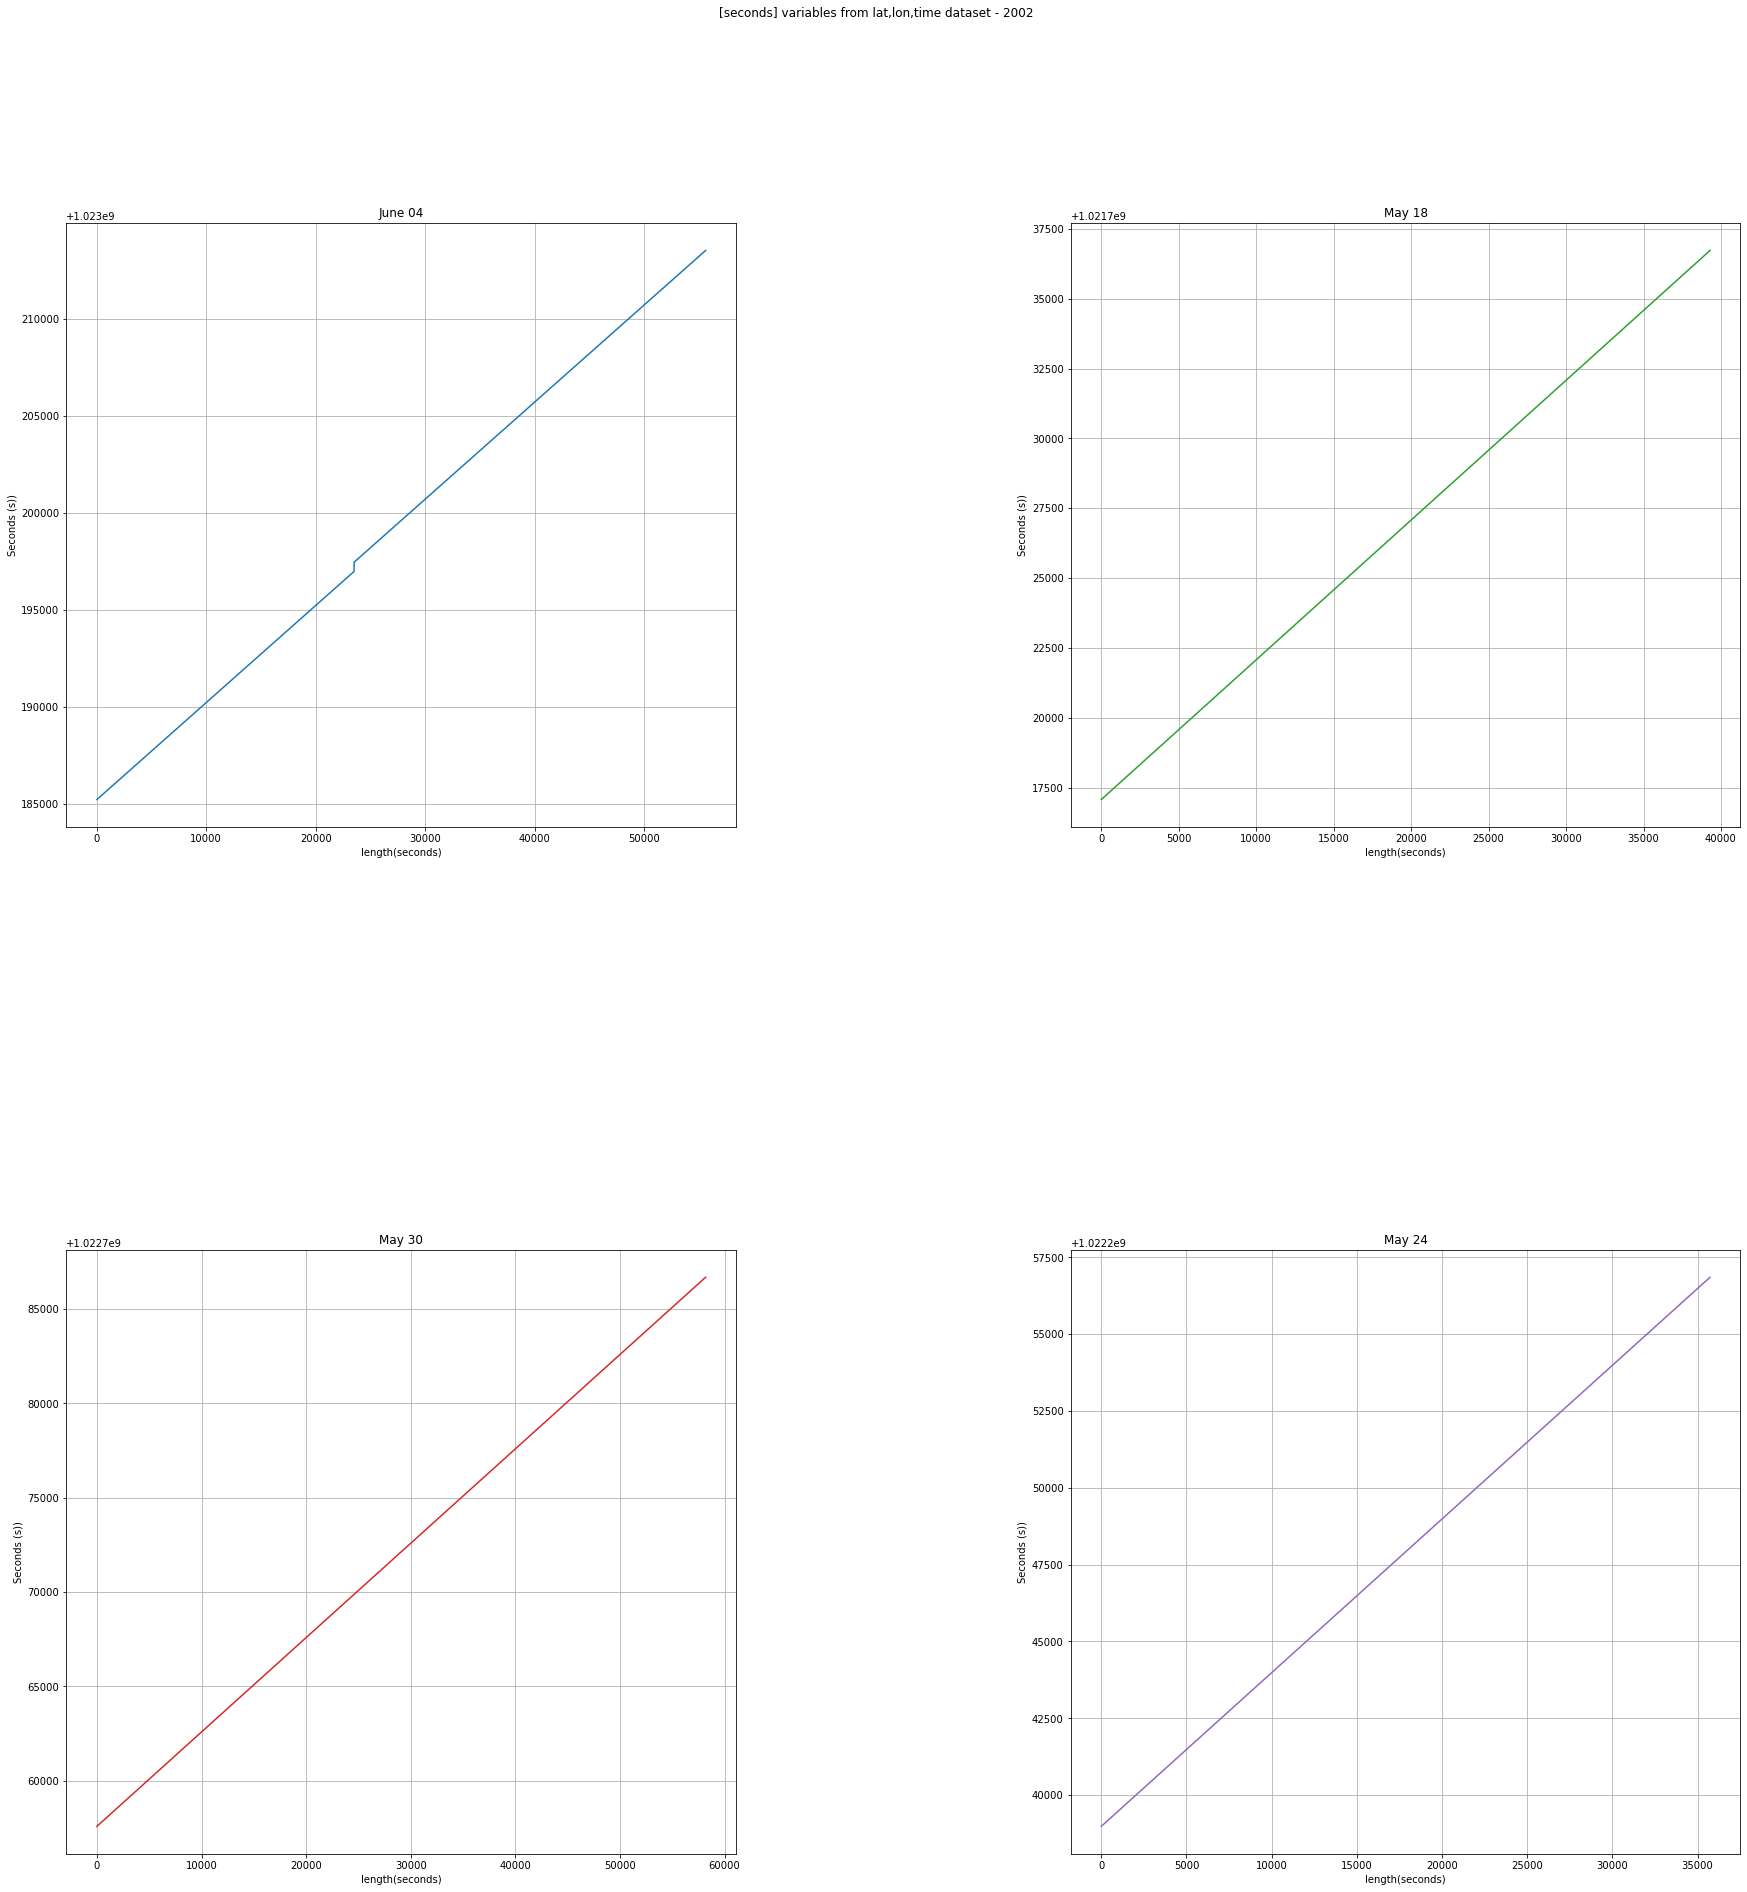

In [10]:
#Store seconds data
june04_sec=june04_2002['seconds']
may18_sec=may18_2002['seconds']
may24_sec=may24_2002['seconds']
may30_sec=may30_2002['seconds']

#Print the lengths of the gps times
print('The length of the seconds vector for May 18 is: ' + str(may18_sec.shape[1]))
print('The length of the seconds vector for May 24 is: ' + str(may24_sec.shape[1]))
print('The length of the seconds vector for May 30 is: ' + str(may30_sec.shape[1]))
print('The length of the seconds vector for Jun 04 is: ' + str(june04_sec.shape[1]))
print(' ')

#Let's use the same x vector to plot

#Plot the seconds
fig, axs = pyplot.subplots(2, 2)
axs[0, 0].plot(x_june04,june04_sec.reshape((june04_sec.size,)),'tab:blue')
axs[0, 0].set_title('June 04')
axs[0, 0].grid()
axs[0, 1].plot(x_may18,may18_sec.reshape((may18_sec.size,)), 'tab:green')
axs[0, 1].set_title('May 18')
axs[0, 1].grid()
axs[1, 0].plot(x_may30,may30_sec.reshape((may30_sec.size,)), 'tab:red')
axs[1, 0].set_title('May 30')
axs[1, 0].grid()
axs[1, 1].plot(x_may24,may24_sec.reshape((may24_sec.size,)), 'tab:purple')
axs[1, 1].set_title('May 24')
axs[1, 1].grid()

fig.suptitle('[seconds] variables from lat,lon,time dataset - 2002')

for ax in axs.flat:
    ax.set(xlabel='length(seconds)', ylabel='Seconds (s))')

pyplot.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.7)

The length of the useconds vector for May 18 is: 39293
The length of the useconds vector for May 24 is: 35733
The length of the useconds vector for May 30 is: 58182
The length of the useconds vector for Jun 04 is: 55636
 


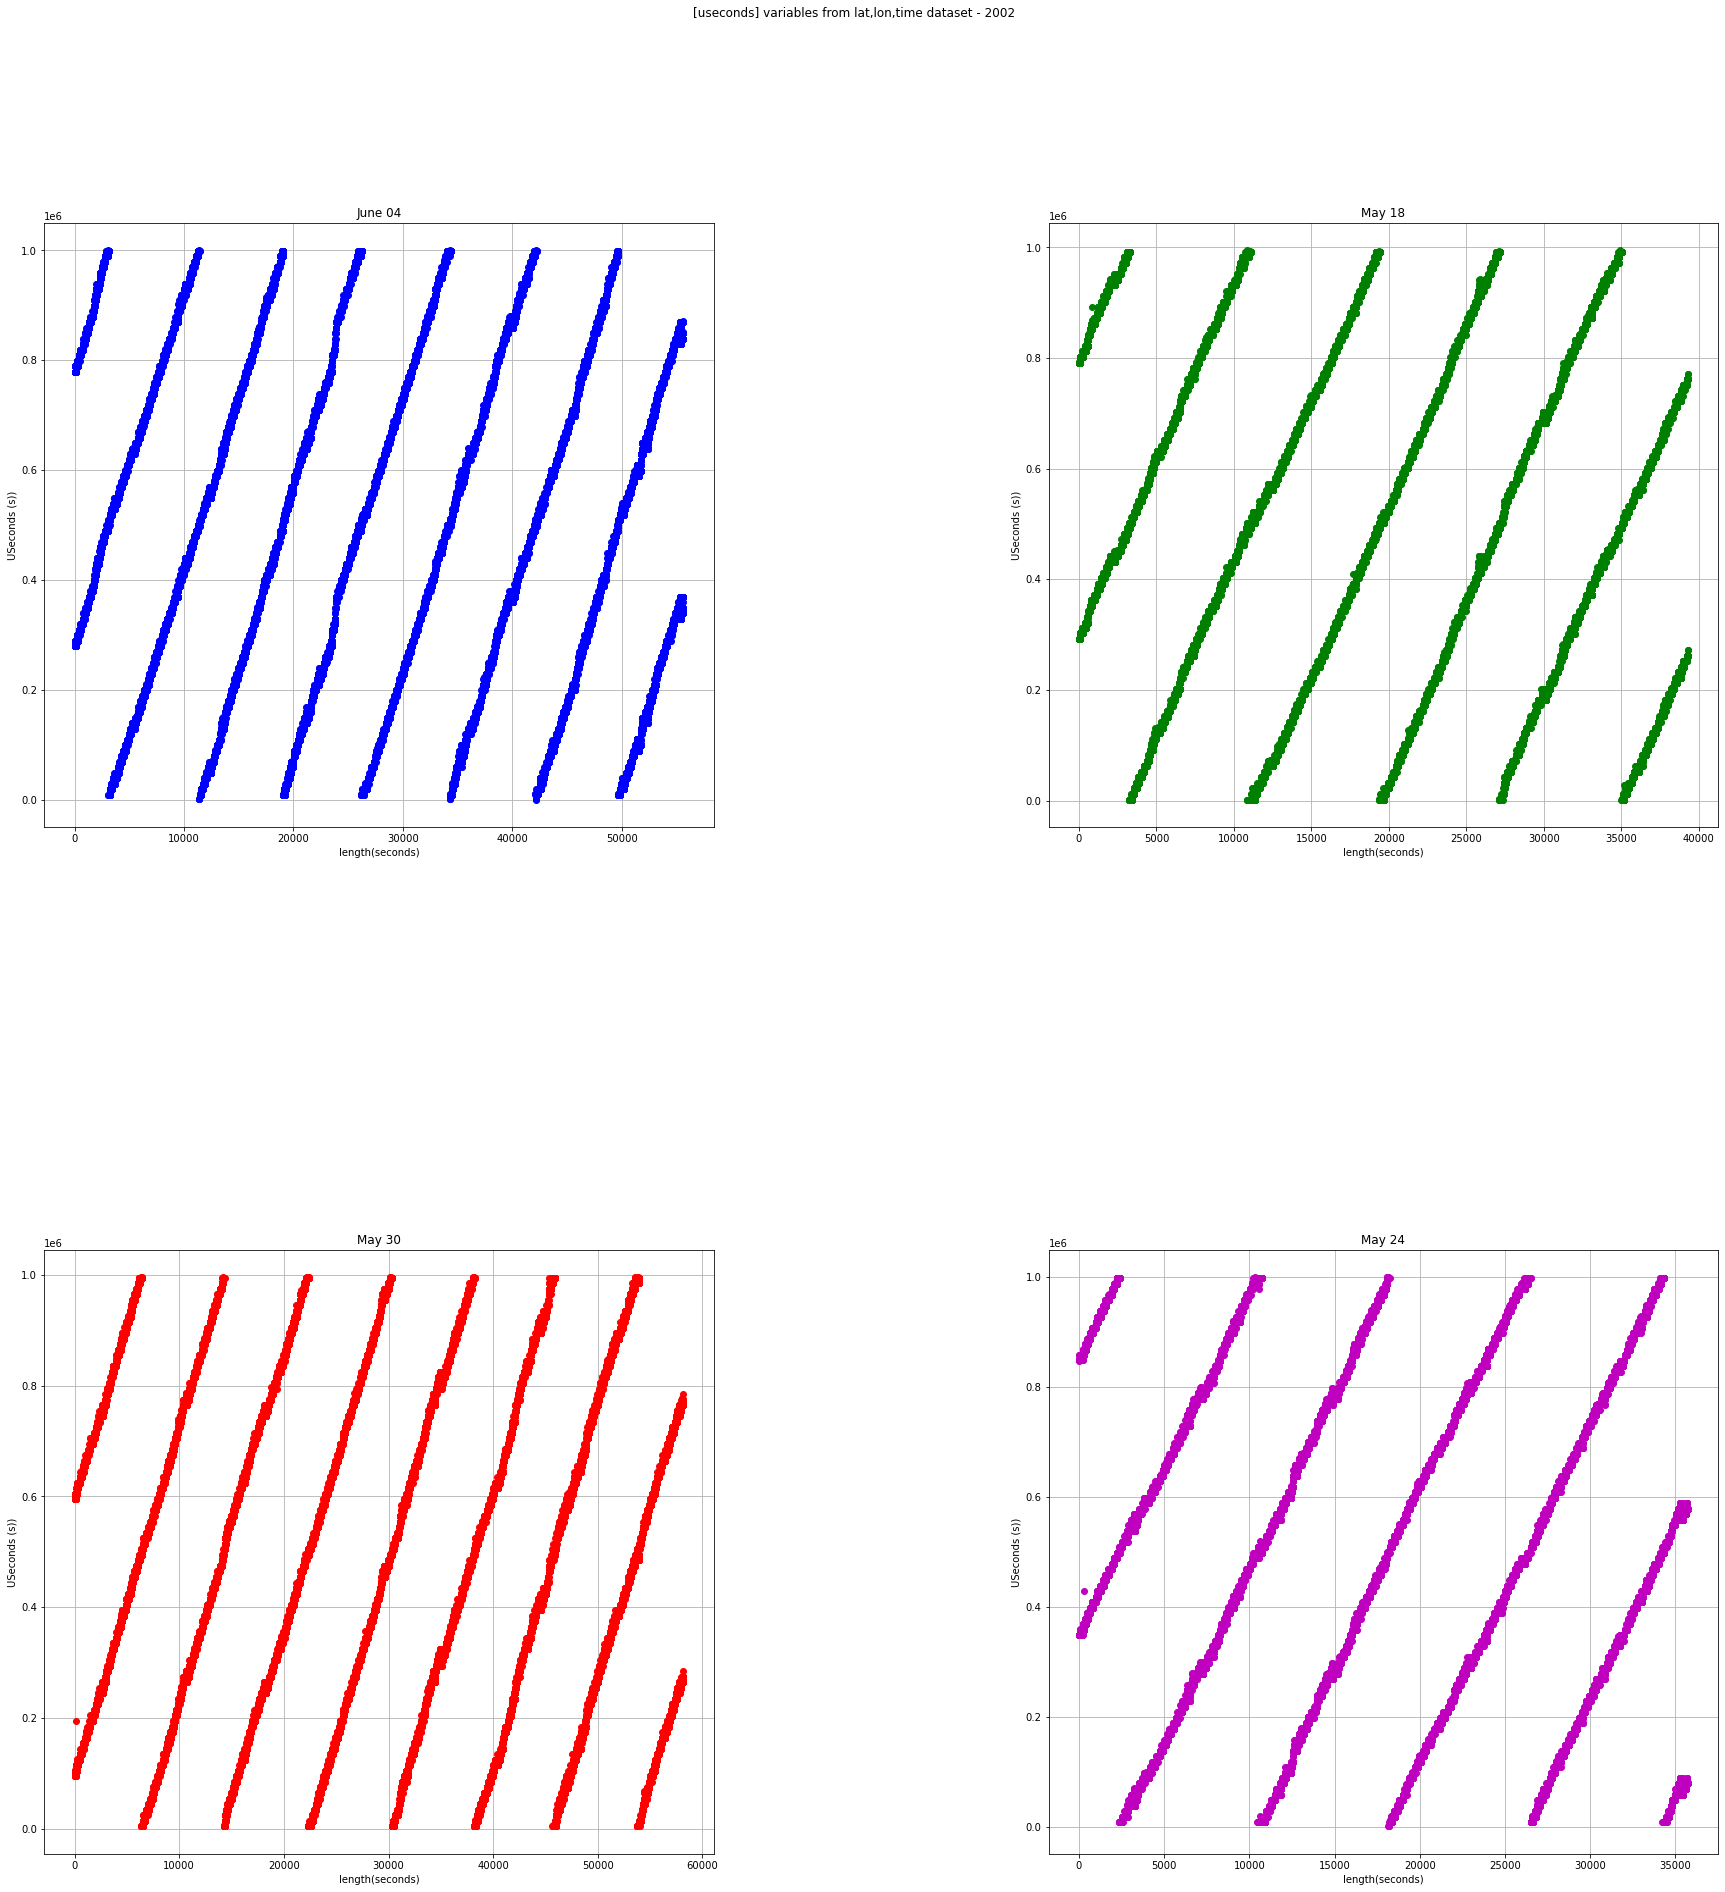

In [11]:
#Store useconds data
june04_usec=june04_2002['useconds']
may18_usec=may18_2002['useconds']
may24_usec=may24_2002['useconds']
may30_usec=may30_2002['useconds']

#Print the lengths of the gps times
print('The length of the useconds vector for May 18 is: ' + str(may18_usec.shape[1]))
print('The length of the useconds vector for May 24 is: ' + str(may24_usec.shape[1]))
print('The length of the useconds vector for May 30 is: ' + str(may30_usec.shape[1]))
print('The length of the useconds vector for Jun 04 is: ' + str(june04_usec.shape[1]))
print(' ')

#Let's use the same x vector to plot

#Plot the seconds
fig, axs = pyplot.subplots(2, 2)
axs[0, 0].plot(x_june04,june04_usec.reshape((june04_usec.size,)),'bo')
axs[0, 0].set_title('June 04')
axs[0, 0].grid()
axs[0, 1].plot(x_may18,may18_usec.reshape((may18_usec.size,)),'go')
axs[0, 1].set_title('May 18')
axs[0, 1].grid()
axs[1, 0].plot(x_may30,may30_usec.reshape((may30_usec.size,)), 'ro')
axs[1, 0].set_title('May 30')
axs[1, 0].grid()
axs[1, 1].plot(x_may24,may24_usec.reshape((may24_usec.size,)), 'mo')
axs[1, 1].set_title('May 24')
axs[1, 1].grid()

fig.suptitle('[useconds] variables from lat,lon,time dataset - 2002')

for ax in axs.flat:
    ax.set(xlabel='length(seconds)', ylabel='USeconds (s))')

pyplot.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.7)

3. `[useconds]` variable

4. `[elh/alt_gps]` variable

The 4 dates store the same variable, except for May 18: it stores the variables 'alt_gps' and no 'elh', whereas the 3 other dates store 'elh' but no 'alt_gps'

|Date  | Variable
|------|------
|May 18 | alt_gps
|May 24 | elh
|May 30 | elh
|Jun 04 | elh

I make the assumption that the data stored are identical, and plot the results herebelow

The length of the alt_gps vector for May 18 is: 39293
The length of the elh vector for May 24 is: 35733
The length of the elh vector for May 30 is: 58182
The length of the elh vector for Jun 04 is: 55636
 


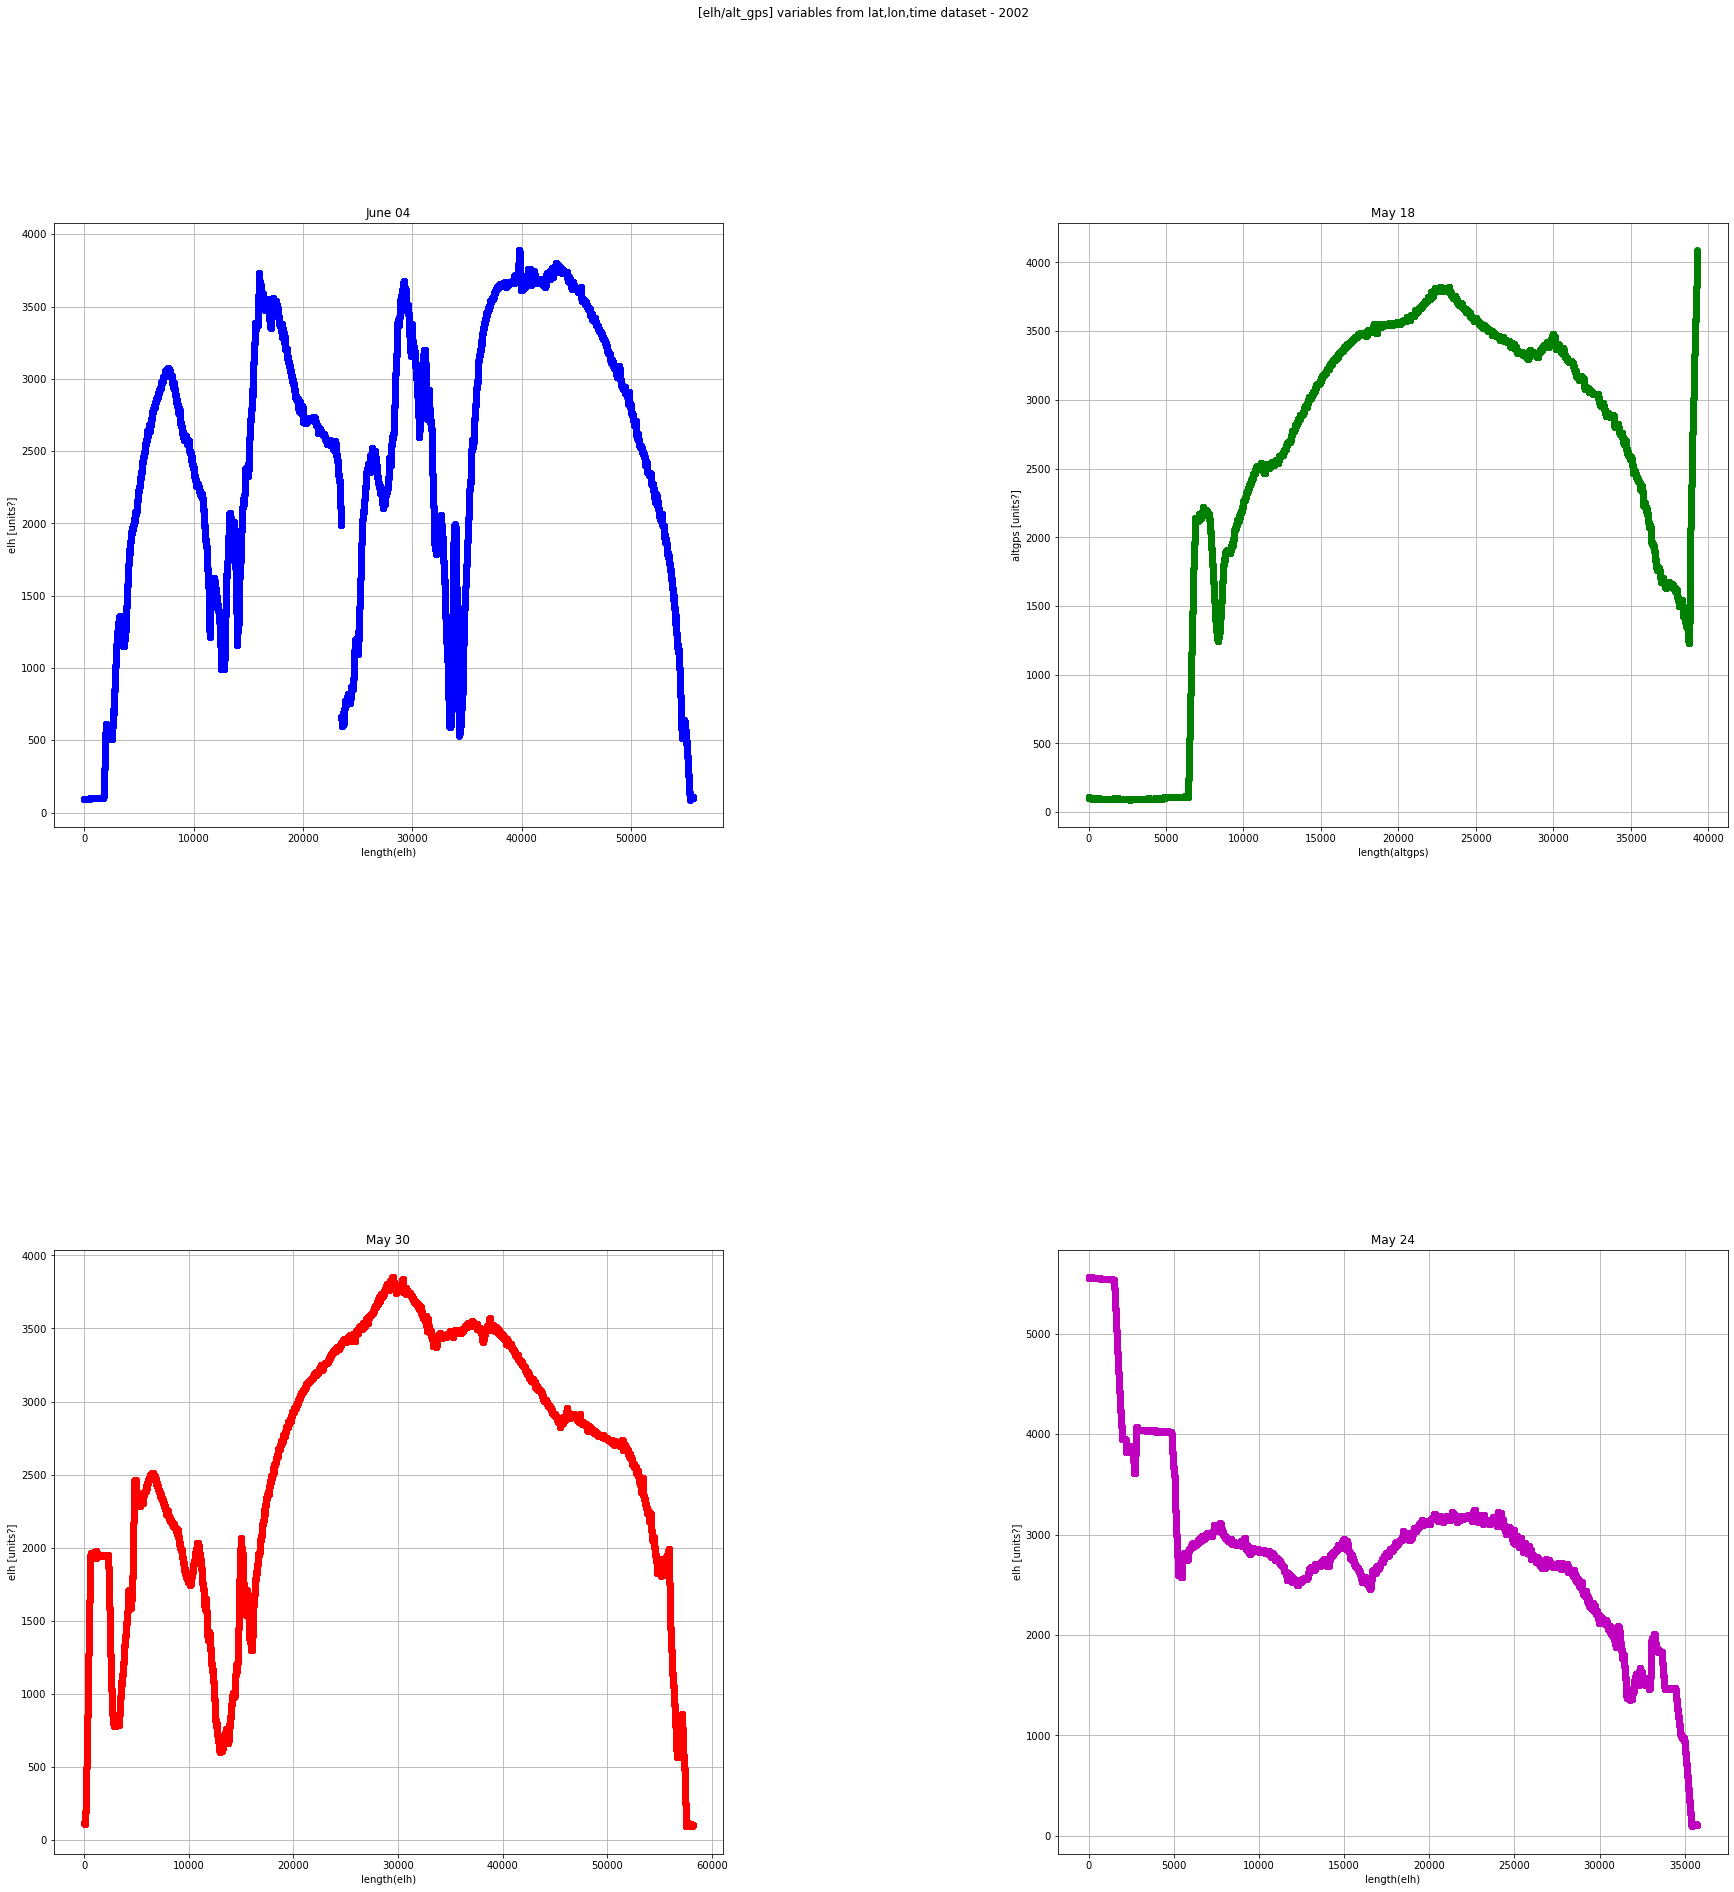

In [12]:
#Store elh data
june04_elh=june04_2002['elh']
may18_altgps=may18_2002['alt_gps']
may24_elh=may24_2002['elh']
may30_elh=may30_2002['elh']

#Print the lengths of the elh and altgps
print('The length of the alt_gps vector for May 18 is: ' + str(may18_altgps.shape[1]))
print('The length of the elh vector for May 24 is: ' + str(may24_elh.shape[1]))
print('The length of the elh vector for May 30 is: ' + str(may30_elh.shape[1]))
print('The length of the elh vector for Jun 04 is: ' + str(june04_elh.shape[1]))
print(' ')

#Plot the GPS time
fig, axs = pyplot.subplots(2, 2)
axs[0, 0].plot(x_june04,june04_elh.reshape((june04_elh.size,)),'bo')
axs[0, 0].set_title('June 04')
axs[0, 0].set(xlabel='length(elh)',ylabel='elh [units?]')
axs[0, 0].grid()
axs[0, 1].plot(x_may18,may18_altgps.reshape((may18_altgps.size,)), 'go')
axs[0, 1].set_title('May 18')
axs[0, 1].set(xlabel='length(altgps)',ylabel='altgps [units?]')
axs[0, 1].grid()

axs[1, 0].plot(x_may30,may30_elh.reshape((may30_elh.size,)), 'ro')
axs[1, 0].set_title('May 30')
axs[1, 0].set(xlabel='length(elh)',ylabel='elh [units?]')
axs[1, 0].grid()

axs[1, 1].plot(x_may24,may24_elh.reshape((may24_elh.size,)), 'mo')
axs[1, 1].set_title('May 24')
axs[1, 1].set(xlabel='length(elh)',ylabel='elh [units?]')
axs[1, 1].grid()

fig.suptitle('[elh/alt_gps] variables from lat,lon,time dataset - 2002')

#for ax in axs.flat:
#    ax.set(xlabel='length(elf)', ylabel='Elf (s))')

pyplot.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.7)

Elh and atl_gps seems to be identical variables, very likelly the elevation of the gps on board.

### 1.d Conclusion (on the investigation of the lat_lon_time dataset for 2002) :
- No need to investigate `lat_gps` and `lon_gps` because I guess it is the coordinates of the flight, but not of the traces!
- `alt_gps` and `elh` are very likely identical variables, I guess corresponding to the elevation the gps
- The `gps_time` and `seconds` variables does not give me any information on the penetration of the signal
- However the `useconds` variable shows an interesting pattern, however I do not think this is related to the penetration of the signal because of the difference in the length of the variables as investigated in part 1.


## I. 2003
### 1. Data and lenght of files 
### 1.a Summary

We have dates where there is data: .

There are 6 dates of data: May 9, 11, 12, 13, 14, 15. All of them have an associated pdf file. In each of this folder of data, there are 2 types of datsets:
- `MMDD_YY_gps_latlontime.map`
- `MMDD_YY_tracenb.mat`

The table below summarizes which variables are stored in each of these files, as well as the dimension of the variables:

| May 09th 2003 | May 11th 2003 | May 12th 2003 | May 13th 2003 | May 14th 2003 | May 15th 2003 || DATA May 9th 2003 | DATA May 11th 2003 | DATA May 12th 2003 | DATA May 13th 2003 | DATA May 14th 2003 | DATA May 15th 2003 |
|---------------|---------------|---------------|---------------|---------------|---------------||------------------- |------------------- |------------------- |------------------- |------------------- |------------------- |
|`may09_03_gpslatlontime.mat`|`may11_03_gpslatlontime.mat`|`may12_03_gpslatlontime.mat`|`may13_03_gpslatlontime.mat`|`may14_03_gpslatlontime.mat`|`may15_03_gpslatlontime.mat`||`may09_03_3.mat`|`may11_03_3.mat`|`may12_03_3.mat`|`may13_03_3.mat`|`may14_03_3.mat`|`may15_03_3.mat`|
|    seconds (1, 56781)   |    seconds (1, 53800)   |    seconds (1, 53627)   |    seconds (1, 42377)   |    seconds (1, 60028)   |    seconds (1, 44906)   ||/|/|/|/|/|/|
|    useconds (1, 56781)  |    useconds (1, 53800)  |    useconds (1, 53627)  |    useconds (1, 42377)  |    useconds (1, 60028)  |    useconds (1, 44906)  ||          /         |/|/|/|/|/|
|    lat_gps (1, 56781)   |    lat_gps (1, 53800)   |    lat_gps (1, 53627)   |    lat_gps (1, 42377)   |    lat_gps (1, 60028)   |    lat_gps (1, 44906)   ||          /         |/|/|/|/|/|
|    lon_gps (1, 56781)   |    lon_gps (1, 53800)   |    lon_gps (1, 53627)   |    lon_gps (1, 42377)   |    lon_gps (1, 60028)   |    lon_gps (1, 44906)   ||          /         |/|/|/|/|/|
|    time_gps (1, 56781)  |    time_gps (1, 53800)  |    time_gps (1, 53627)  |    time_gps (1, 42377)  |    time_gps (1, 60028)  |    time_gps (1, 44906)  ||          /         |/|/|/|/|/|
|       /       |       /       |       /       |       /       |       /       |       /       || filtfi (4095, 1000) | filtfi (4095, 1000) | filtfi (4095, 1000) | filtfi (4095, 1000) | filtfi (4095, 1000) | filtfi (4095, 1000) |
|       /       |       /       |       /       |       /       |       /       |       /       || timearr (1, 1000) | timearr (1, 1000) | timearr (1, 1000) | timearr (1, 1000) | timearr (1, 1000) | timearr (1, 1000) |


Basically this is the same data output as for 2002 dataset (expect for june 04 2002).

Problem: there not seems to be a time variable associated with the data to allow me for retreiving the depth of the echogram. I need a time variable lenght to be equal to 4095. No such variable exsit. I am thus having a look at the variables that have a time dimension: maybe the time variable of any trace have been appended one after each other in a variable. Thus, I am need to:
1. Pick up a date and sum the length of the of the depths of any trace to know the total sum of this hypothetical time variable
2. Look into the any variable that have a time dimension in the corresponding `MMDD_YY_latlontime.mat` file

### The big difference with 2002 is that in 2003 dataset, there are individual pdf files that allow me to choose the track where I expect to see ice slabs.
### 1.b Let's choose the date May 13 2003

In [14]:
#load individual data
may13_03_0= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_0.mat')
may13_03_1= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_1.mat')
may13_03_2= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_2.mat')
may13_03_3= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_3.mat')
may13_03_4= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_4.mat')
may13_03_5= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_5.mat')
may13_03_6= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_6.mat')
may13_03_7= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_7.mat')
may13_03_8= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_8.mat')
may13_03_9= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_9.mat')
may13_03_10= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_10.mat')
may13_03_11= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_11.mat')
may13_03_12= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_12.mat')
may13_03_13= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_13.mat')
may13_03_14= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_14.mat')
may13_03_15= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_15.mat')
may13_03_16= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_16.mat')
may13_03_17= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_17.mat')
may13_03_18= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_18.mat')
may13_03_19= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_19.mat')
may13_03_20= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_20.mat')
may13_03_21= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_21.mat')
may13_03_22= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_22.mat')
may13_03_23= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_23.mat')
may13_03_24= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_24.mat')
may13_03_25= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_25.mat')
may13_03_26= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_26.mat')
may13_03_27= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_27.mat')
may13_03_28= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_28.mat')
may13_03_29= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_29.mat')
may13_03_30= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_30.mat')

#store the filtfin to obtain the length of the depth
may13_03_0_filtfin= may13_03_0['filtfin']
may13_03_1_filtfin= may13_03_1['filtfin']
may13_03_2_filtfin= may13_03_2['filtfin']
may13_03_3_filtfin= may13_03_3['filtfin']
may13_03_4_filtfin= may13_03_4['filtfin']
may13_03_5_filtfin= may13_03_5['filtfin']
may13_03_6_filtfin= may13_03_6['filtfin']
may13_03_7_filtfin= may13_03_7['filtfin']
may13_03_8_filtfin= may13_03_8['filtfin']
may13_03_9_filtfin= may13_03_9['filtfin']
may13_03_10_filtfin= may13_03_10['filtfin']
may13_03_11_filtfin= may13_03_11['filtfin']
may13_03_12_filtfin= may13_03_12['filtfin']
may13_03_13_filtfin= may13_03_13['filtfin']
may13_03_14_filtfin= may13_03_14['filtfin']
may13_03_15_filtfin= may13_03_15['filtfin']
may13_03_16_filtfin= may13_03_16['filtfin']
may13_03_17_filtfin= may13_03_17['filtfin']
may13_03_18_filtfin= may13_03_18['filtfin']
may13_03_19_filtfin= may13_03_19['filtfin']
may13_03_20_filtfin= may13_03_20['filtfin']
may13_03_21_filtfin= may13_03_21['filtfin']
may13_03_22_filtfin= may13_03_22['filtfin']
may13_03_23_filtfin= may13_03_23['filtfin']
may13_03_24_filtfin= may13_03_24['filtfin']
may13_03_25_filtfin= may13_03_25['filtfin']
may13_03_26_filtfin= may13_03_26['filtfin']
may13_03_27_filtfin= may13_03_27['filtfin']
may13_03_28_filtfin= may13_03_28['filtfin']
may13_03_29_filtfin= may13_03_29['filtfin']
may13_03_30_filtfin= may13_03_30['filtfin']

#store the timearr to obtain the length of the timearr variable
may13_03_0_timearr= may13_03_0['timearr']

#Load the gps latlontime file for May 13
may13_03_gpslatlontime= scipy.io.loadmat('C://Users//Nicolas Jullien//Documents//PhD//iceslabs_processing//iceslabs_MacFerrin//data//2003//may13//may13_03_gpslatlontime.mat')

#Print the sum of the shapes
print('The sum of the depths for all files in May 13 2003 is:')
print(may13_03_0_filtfin.shape[0]+may13_03_1_filtfin.shape[0]+may13_03_2_filtfin.shape[0]+may13_03_3_filtfin.shape[0]+may13_03_4_filtfin.shape[0]+may13_03_5_filtfin.shape[0]+may13_03_6_filtfin.shape[0]+may13_03_7_filtfin.shape[0]+may13_03_8_filtfin.shape[0]+may13_03_9_filtfin.shape[0]+may13_03_10_filtfin.shape[0]+may13_03_11_filtfin.shape[0]+may13_03_12_filtfin.shape[0]+may13_03_13_filtfin.shape[0]+may13_03_14_filtfin.shape[0]+may13_03_15_filtfin.shape[0]+may13_03_16_filtfin.shape[0]+may13_03_17_filtfin.shape[0]+may13_03_18_filtfin.shape[0]+may13_03_19_filtfin.shape[0]+may13_03_20_filtfin.shape[0]+may13_03_21_filtfin.shape[0]+may13_03_22_filtfin.shape[0]+may13_03_23_filtfin.shape[0]+may13_03_24_filtfin.shape[0]+may13_03_25_filtfin.shape[0]+may13_03_26_filtfin.shape[0]+may13_03_27_filtfin.shape[0]+may13_03_28_filtfin.shape[0]+may13_03_29_filtfin.shape[0]+may13_03_30_filtfin.shape[0])
print('The sum of the horizontal distance for all files in May 13 2003 is:')
print(may13_03_0_filtfin.shape[1]+may13_03_1_filtfin.shape[1]+may13_03_2_filtfin.shape[1]+may13_03_3_filtfin.shape[1]+may13_03_4_filtfin.shape[1]+may13_03_5_filtfin.shape[1]+may13_03_6_filtfin.shape[1]+may13_03_7_filtfin.shape[1]+may13_03_8_filtfin.shape[1]+may13_03_9_filtfin.shape[1]+may13_03_10_filtfin.shape[1]+may13_03_11_filtfin.shape[1]+may13_03_12_filtfin.shape[1]+may13_03_13_filtfin.shape[1]+may13_03_14_filtfin.shape[1]+may13_03_15_filtfin.shape[1]+may13_03_16_filtfin.shape[1]+may13_03_17_filtfin.shape[1]+may13_03_18_filtfin.shape[1]+may13_03_19_filtfin.shape[1]+may13_03_20_filtfin.shape[1]+may13_03_21_filtfin.shape[1]+may13_03_22_filtfin.shape[1]+may13_03_23_filtfin.shape[1]+may13_03_24_filtfin.shape[1]+may13_03_25_filtfin.shape[1]+may13_03_26_filtfin.shape[1]+may13_03_27_filtfin.shape[1]+may13_03_28_filtfin.shape[1]+may13_03_29_filtfin.shape[1]+may13_03_30_filtfin.shape[1])
#Print file characteristics

print('Dimension of the seconds variable in the file may13_03_gpslatlontime.mat')
print(may13_03_gpslatlontime['seconds'].shape)
print('Dimension of the useconds variable in the file may13_03_gpslatlontime.mat')
print(may13_03_gpslatlontime['useconds'].shape)
print('Dimension of the time_gps variable in the file may13_03_gpslatlontime.mat')
print(may13_03_gpslatlontime['time_gps'].shape)
print('Dimension of the latitude variable in the file may13_03_gpslatlontime.mat')
print(may13_03_gpslatlontime['lat_gps'].shape)
print('Dimension of the time_gps variable in the file may13_03_gpslatlontime.mat')
print(may13_03_gpslatlontime['lon_gps'].shape)
print(' ')
print('The size of the timearr (from individual track file) is:')
print(may13_03_0_timearr.shape)
print('The size of the filtfin (from individual track file) is:')
print(may13_03_0_filtfin.shape)

The sum of the depths for all files in May 13 2003 is:
126945
The sum of the horizontal distance for all files in May 13 2003 is:
30330
Dimension of the seconds variable in the file may13_03_gpslatlontime.mat
(1, 42377)
Dimension of the useconds variable in the file may13_03_gpslatlontime.mat
(1, 42377)
Dimension of the time_gps variable in the file may13_03_gpslatlontime.mat
(1, 42377)
Dimension of the latitude variable in the file may13_03_gpslatlontime.mat
(1, 42377)
Dimension of the time_gps variable in the file may13_03_gpslatlontime.mat
(1, 42377)
 
The size of the timearr (from individual track file) is:
(1, 1000)
The size of the filtfin (from individual track file) is:
(4095, 1000)


### The sum of the depth for all files if 126'945 != 42'377. The time variable associated with the radar echogram is not present for 2003 dataset.

Nevertheless, I am investigating herebelow what are inside the matrices, to see if we can spot ice slabs (or not).

### 1.c I am not going to look into variables stored in the master files to see if we cannot extract anything because I did that for 2002, unsuccessfully.

### After discussion with Andrew presenting to him the latter results, we found a way to find the latitude and longitude related to each trace. This is work in progress, in the code `retreive_latlon_2002_2003_AR.py`: I find the match between the `timearr` variable in individial trace files with the `seconds` variable in the mater files.

### After email exchange with John Paden, he indictated to me how to calculate the two-way travel time variable.